# 1. Different NN
# 1.1 NN
# 1.2 CNN, CNN+Maxpooling

100%|██████████| 9912422/9912422 [00:00<00:00, 101599442.94it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 48184444.64it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27308015.23it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8044986.81it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

5
60000
torch.Size([1, 28, 28])


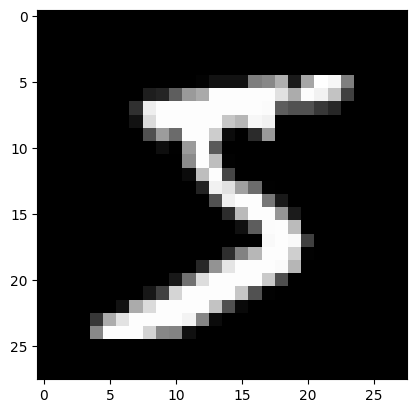

In [2]:
#Printing digits in the Dataset

import torch
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Lambda, Compose, Normalize

transform = Compose([
    ToTensor(),  # Convert images to PyTorch tensors
    Normalize(mean=[0.5], std=[0.5]) # Scale pixel values to the range [-1, 1]
])


# Download the MNIST dataset
train_data = MNIST(root='./data', train=True, download=True, transform=transform)
test_data = MNIST(root='./data', train=False, download=True, transform=transform)

plt.imshow(train_data[0][0].reshape(28,28),cmap='gray')
print(train_data[0][1])
print(len(train_data))
print(train_data[0][0].shape)


In [3]:
#checking the device on which we're running
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
import time

def applySoftmax(f_hat):
  return nn.functional.softmax(f_hat,dim =1)


class NN_1(nn.Module):
    def __init__(self) -> None:
         super().__init__() #
         self.flatten = nn.Flatten()
         self.network_stack= nn.Sequential(
         nn.Linear(784,1000),
         nn.ReLU(),
         nn.Linear(1000,10)) # output and final layer must match
    def forward(self,f_hat):
        f_hat = self.flatten(f_hat)
        f_hat = self.network_stack(f_hat)
        #f_hat = applySoftmax(f_hat)
        return f_hat

class NN_2(nn.Module):
    def __init__(self) -> None:
         super().__init__() #
         self.flatten = nn.Flatten()
         self.network_stack= nn.Sequential(
         nn.Linear(784,1000),
         nn.Sigmoid(),
         nn.Linear(1000,10)) # output and final layer must match
    def forward(self,f_hat):
        f_hat = self.flatten(f_hat)
        f_hat = self.network_stack(f_hat)
        #f_hat = applySoftmax(f_hat)
        return f_hat

class NN_3(nn.Module): #CNN just Conv layer
    def __init__(self) -> None:
         super().__init__() #
         self.network_stack= nn.Sequential(
         nn.Conv2d(in_channels=1,    # Number of channels in the input image (1 for grayscale)
                   out_channels=1,   # Number of channels produced by the convolution (number of filters)
                   kernel_size=3,    # Size of the convolving kernel (3x3)
                   stride=1,         # Stride of the convolution
                   padding=0),        # No padding,
         nn.Flatten(),
         nn.Linear(26*26*1,1000),
         nn.ReLU(),
         nn.Linear(1000,10)) # output and final layer must match
    def forward(self,f_hat):
        f_hat = self.network_stack(f_hat)
        #f_hat = applySoftmax(f_hat)
        return f_hat

class NN_4(nn.Module):  #Conv layer + max pooling
    def __init__(self) -> None:
         super().__init__() #
         self.network_stack= nn.Sequential(
         nn.Conv2d(in_channels=1,    # Number of channels in the input image (1 for grayscale)
                   out_channels=1,   # Number of channels produced by the convolution (number of filters)
                   kernel_size=3,    # Size of the convolving kernel (3x3)
                   stride=1,         # Stride of the convolution
                   padding=0),        # No padding,
         nn.MaxPool2d(kernel_size=3,stride=1,padding=0),
         nn.Flatten(),
         nn.Linear(24*24*1,1000),
         nn.ReLU(),
         nn.Linear(1000,10)) # output and final layer must match
    def forward(self,f_hat):
        f_hat = self.network_stack(f_hat)
        #f_hat = applySoftmax(f_hat)
        return f_hat

#loss function
loss_metric = nn.CrossEntropyLoss()

networks = [NN_1(), NN_2(),NN_3(),NN_4()]

# Data loaders
batch_size = 500  # Define your batch size
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False,num_workers=2)

num_episodes = 50

def parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# NN Train Test method

In [5]:
def NN_train_test(train_loader, test_loader, train_loss_mean_nn1, test_loss_mean_nn1, train_acc_mean_nn1, test_acc_mean_nn1, net, optimizer):
    #to reset the parameters
    for layer in net.children():
     if hasattr(layer,"reset_parameters"):
         layer.reset_parameters()
    if optimizer == "SGD":
        optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
        print("SGD optim")
    else:
        optimizer = optim.Adam(net.parameters(), lr=0.01)
        print("Adam optim")

    train_loss_mean_nn1 = []
    test_loss_mean_nn1 = []
    train_acc_mean_nn1 = []  # List to store training accuracy
    test_acc_mean_nn1 = []   # List to store testing accuracy

    net = net.to(device)  # Move the model to GPU
    for episode in range(num_episodes):
        start = time.time()
        train_loss = []
        correct_train = 0  # Counter for correct predictions on training data
        total_train = 0    # Counter for total samples in training data

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU
            if isinstance(net, (NN_3, NN_4)):
                inputs = inputs.view(-1, 1, 28, 28)  # Reshape to [64, 1, 28, 28]
            optimizer.zero_grad()
            Predict = net(inputs)
            loss = loss_metric(Predict, targets)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            _, predicted_train = torch.max(Predict.data, 1)  # Get predicted labels
            correct_train += (predicted_train == targets).sum().item()  # Count correct predictions
            total_train += targets.size(0)  # Count total samples

        # Calculate training accuracy
        train_accuracy = correct_train / total_train

        with torch.no_grad():
            test_loss = []
            correct_test = 0   # Counter for correct predictions on testing data
            total_test = 0     # Counter for total samples in testing data

            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU
                if isinstance(net, (NN_3, NN_4)):
                    inputs = inputs.view(-1, 1, 28, 28)  # Reshape to [64, 1, 28, 28]
                Predict = net(inputs)
                loss = loss_metric(Predict, targets)
                test_loss.append(loss.item())
                _, predicted_test = torch.max(Predict.data, 1)  # Get predicted labels
                correct_test += (predicted_test == targets).sum().item()  # Count correct predictions
                total_test += targets.size(0)  # Count total samples

        # Calculate testing accuracy
        test_accuracy = correct_test / total_test

        train_loss_mean_nn1.append(np.mean(train_loss))
        test_loss_mean_nn1.append(np.mean(test_loss))
        train_acc_mean_nn1.append(train_accuracy)
        test_acc_mean_nn1.append(test_accuracy)
        end = time.time()
        print(f"{episode} {end - start:.2f}", end=', ')

    return train_loss_mean_nn1, test_loss_mean_nn1, train_acc_mean_nn1, test_acc_mean_nn1


def plot_loss(train_loss, test_loss, train_acc, test_acc, num_params):
    """
    Function to plot loss and accuracy
    """
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(8, 12))

    ax1.plot(train_loss)
    ax1.set_title(f"Training loss over episodes, Parameters {num_params}")
    ax1.set_ylabel("Loss")
    ax1.grid()

    ax2.plot(test_loss)
    ax2.set_title(f"Test loss over episodes, Parameters {num_params}")
    ax2.set_ylabel("Loss")
    ax2.set_xlabel("Episodes")
    ax2.grid()

    ax3.plot(train_acc)
    ax3.set_title(f"Training accuracy over episodes, Parameters {num_params}")
    ax3.set_ylabel("Accuracy")
    ax3.grid()

    ax4.plot(test_acc)
    ax4.set_title(f"Test accuracy over episodes, Parameters {num_params}")
    ax4.set_ylabel("Accuracy")
    ax4.set_xlabel("Episodes")
    ax4.grid()

    plt.tight_layout()
    plt.show()




# NN1 - ReLu, Optim = SGD

SGD optim
0 13.94, 1 13.45, 2 13.74, 3 13.52, 4 13.45, 5 13.66, 6 13.57, 7 13.70, 8 13.45, 9 13.56, 10 13.76, 11 13.65, 12 13.83, 13 13.44, 14 13.72, 15 14.20, 16 13.63, 17 13.46, 18 13.68, 19 13.54, 20 13.53, 21 13.65, 22 13.34, 23 13.92, 24 13.55, 25 13.53, 26 13.62, 27 13.60, 28 13.60, 29 13.68, 30 13.60, 31 13.63, 32 13.63, 33 13.65, 34 13.55, 35 13.41, 36 13.69, 37 13.84, 38 13.58, 39 13.74, 40 13.60, 41 13.57, 42 13.69, 43 13.56, 44 13.52, 45 13.26, 46 13.64, 47 13.44, 48 13.82, 49 13.55, train_loss: [0.7087751984596252, 0.3341100671639045, 0.2944656753291686, 0.2652922529727221, 0.24162721460064251, 0.218560524781545, 0.20004526463647684, 0.18195042523245017, 0.16798760990301767, 0.15537452772259713, 0.1438905211786429, 0.13393409916510185, 0.12573666019986074, 0.11839491383483013, 0.11098273073633512, 0.10480300073201458, 0.09972999375313521, 0.09463492818176747, 0.08950523668900132, 0.08505840642998616, 0.082355269882828, 0.07844560323283076, 0.07537684881438812, 0.07171113441

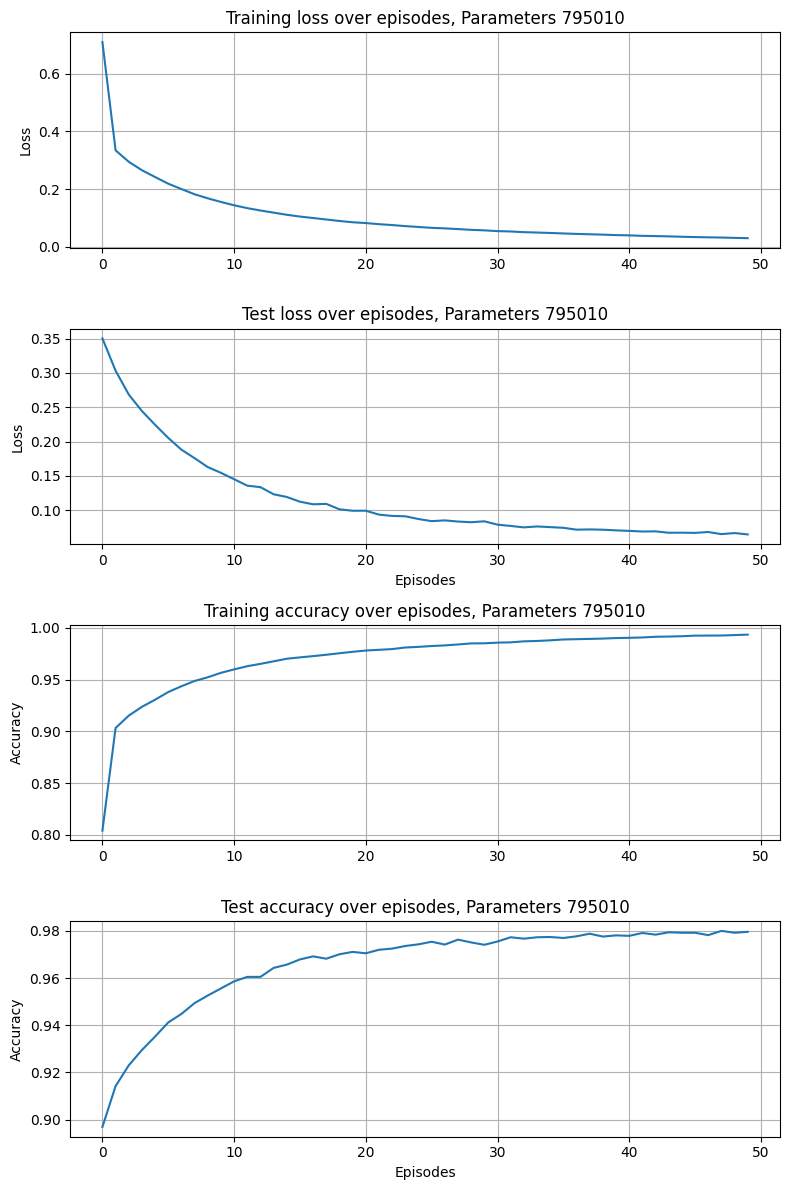

In [15]:
train_loss_mean_nn1 = []
test_loss_mean_nn1 = []
train_acc_mean_nn1 = []
test_acc_mean_nn1 = []
train_loss_mean_nn1, test_loss_mean_nn1, train_acc_mean_nn1, test_acc_mean_nn1 = NN_train_test(train_loader, test_loader, train_loss_mean_nn1, test_loss_mean_nn1, train_acc_mean_nn1, test_acc_mean_nn1, networks[0],"SGD")
print('train_loss: {}\n test_loss: {}\n train_acc: {}\n test_acc: {}'.format(train_loss_mean_nn1,test_loss_mean_nn1,train_acc_mean_nn1, test_acc_mean_nn1))
plot_loss(train_loss_mean_nn1,test_loss_mean_nn1,train_acc_mean_nn1, test_acc_mean_nn1, parameters(networks[0]))

# NN1 - ReLu, Optim = ADAM

Adam optim
0 7.74, 1 7.83, 2 8.28, 3 7.68, 4 7.72, 5 8.14, 6 8.19, 7 7.91, 8 8.40, 9 8.82, 10 8.41, 11 8.57, 12 7.80, 13 8.68, 14 8.35, 15 8.33, 16 8.38, 17 8.58, 18 8.26, 19 8.79, 20 7.97, 21 8.11, 22 7.93, 23 7.96, 24 7.69, 25 8.08, 26 7.79, 27 7.75, 28 7.57, 29 8.16, 30 7.85, 31 7.85, 32 7.73, 33 8.06, 34 7.76, 35 7.75, 36 7.64, 37 8.11, 38 7.64, 39 8.09, 40 7.57, 41 7.93, 42 7.57, 43 7.75, 44 7.66, 45 8.02, 46 7.80, 47 7.77, 48 7.48, 49 7.90, train_loss: [0.11094695820162694, 0.09588000175232689, 0.09943500868976116, 0.09640372352053722, 0.09064147736256321, 0.08199169961735606, 0.08184809403804441, 0.08138270021105806, 0.08043089588172733, 0.08036500359885394, 0.08286025885803004, 0.07113573510820667, 0.07822451149113477, 0.07283183493030568, 0.06754212485005458, 0.06849600065809985, 0.0669567095891883, 0.06705637366200487, 0.07321789174651107, 0.05645226207561791, 0.07066883978744348, 0.06842470662668347, 0.06056455277527372, 0.06441813603353998, 0.06380032682791352, 0.0614839791

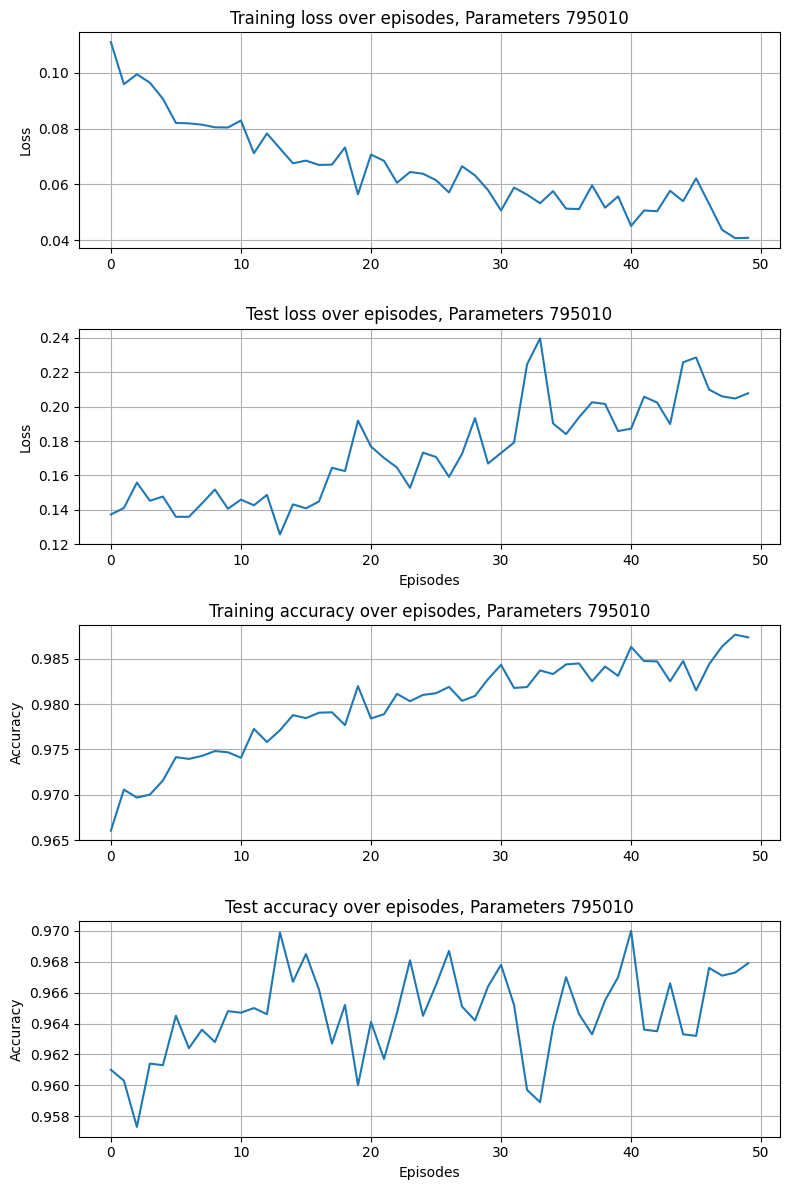

In [40]:
train_loss_mean_nn12 = []
test_loss_mean_nn12 = []
train_acc_mean_nn12 = []
test_acc_mean_nn12 = []
train_loss_mean_nn12, test_loss_mean_nn12, train_acc_mean_nn12, test_acc_mean_nn12 = NN_train_test(train_loader, test_loader, train_loss_mean_nn12, test_loss_mean_nn12, train_acc_mean_nn12, test_acc_mean_nn12, networks[0],"ADAM")
print('train_loss: {}\n test_loss: {}\n train_acc: {}\n test_acc: {}'.format(train_loss_mean_nn12,test_loss_mean_nn12,train_acc_mean_nn12, test_acc_mean_nn12))
plot_loss(train_loss_mean_nn12,test_loss_mean_nn12,train_acc_mean_nn12, test_acc_mean_nn12, parameters(networks[0]))

NN2 - Sigmoid, Optim = SGD

SGD optim
0 7.70, 1 7.63, 2 7.61, 3 7.95, 4 7.69, 5 7.71, 6 7.54, 7 7.90, 8 7.53, 9 7.66, 10 7.66, 11 7.91, 12 7.56, 13 7.74, 14 7.62, 15 7.85, 16 7.45, 17 7.48, 18 7.58, 19 7.95, 20 8.03, 21 7.76, 22 7.92, 23 7.86, 24 7.88, 25 7.91, 26 7.93, 27 8.21, 28 8.03, 29 7.94, 30 7.85, 31 8.34, 32 7.88, 33 7.77, 34 7.89, 35 8.26, 36 8.03, 37 7.81, 38 7.67, 39 8.10, 40 7.82, 41 8.03, 42 7.93, 43 8.16, 44 7.84, 45 7.82, 46 7.87, 47 8.24, 48 7.88, 49 7.87, train_loss: [1.4979011714458466, 0.6166353464126587, 0.4644432616730531, 0.40868585333228113, 0.3774561119576295, 0.35796570479869844, 0.3442413628101349, 0.33322847026089825, 0.32559416219592097, 0.3187786564230919, 0.3140702422708273, 0.30761785556872684, 0.30359274223446847, 0.2987035332868497, 0.2958376164237658, 0.2923917292306821, 0.2893272899091244, 0.2862683802843094, 0.2839333791285753, 0.280916303396225, 0.2785726025700569, 0.27565821496148907, 0.27234697826206683, 0.2701900629947583, 0.2669702758391698, 0.26504044557611145, 0.2631696

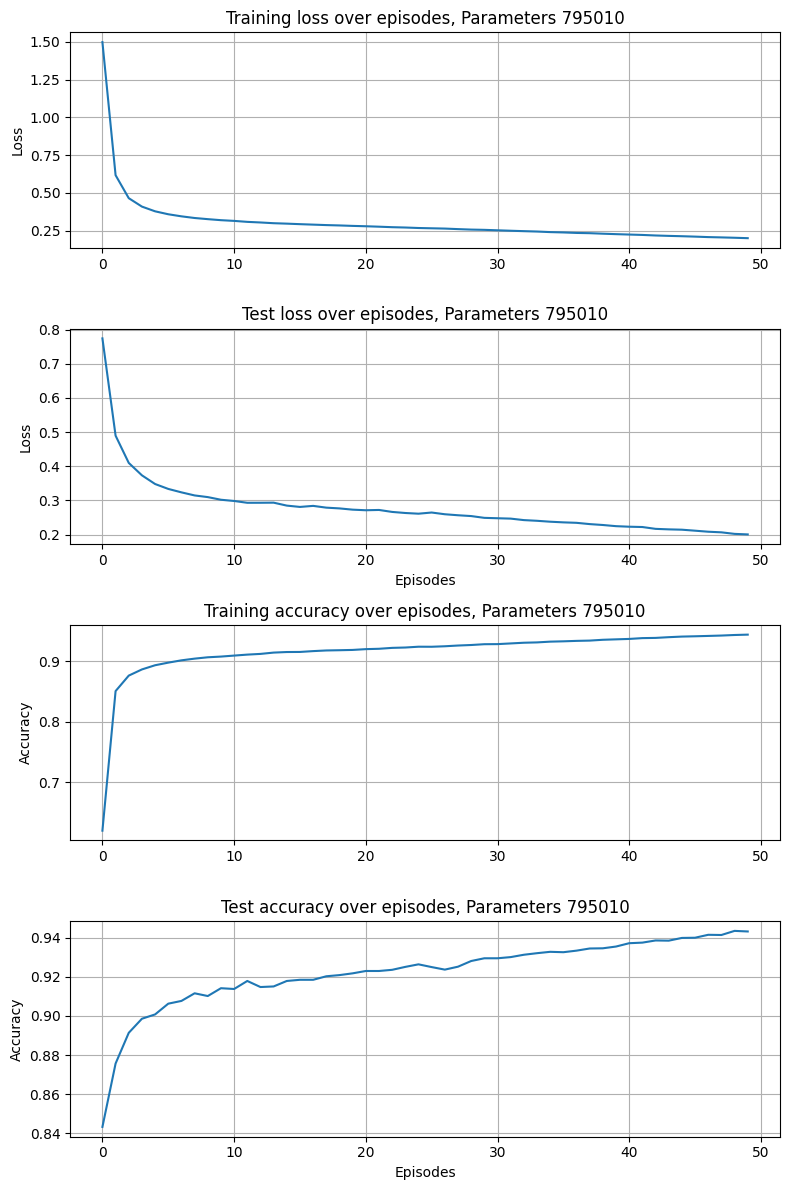

In [41]:
train_loss_mean_nn2 = []
test_loss_mean_nn2 = []
train_acc_mean_nn2 = []
test_acc_mean_nn2 = []
train_loss_mean_nn2, test_loss_mean_nn2, train_acc_mean_nn2, test_acc_mean_nn2 = NN_train_test(train_loader, test_loader, train_loss_mean_nn2, test_loss_mean_nn2, train_acc_mean_nn2, test_acc_mean_nn2, networks[1],"SGD")
print('train_loss: {}\n test_loss: {}\n train_acc: {}\n test_acc: {}'.format(train_loss_mean_nn2,test_loss_mean_nn2,train_acc_mean_nn2, test_acc_mean_nn2))
plot_loss(train_loss_mean_nn2,test_loss_mean_nn2,train_acc_mean_nn2, test_acc_mean_nn2, parameters(networks[1]))

# NN2 - Sigmoid, Optim = ADAM

Adam optim
0 7.81, 1 8.30, 2 7.84, 3 7.70, 4 7.80, 5 8.06, 6 7.95, 7 7.84, 8 7.81, 9 8.13, 10 7.87, 11 7.91, 12 7.85, 13 8.12, 14 7.98, 15 8.14, 16 7.93, 17 8.31, 18 7.74, 19 7.84, 20 7.77, 21 8.19, 22 7.94, 23 7.89, 24 7.88, 25 8.27, 26 7.85, 27 7.80, 28 7.71, 29 8.34, 30 7.91, 31 7.91, 32 8.05, 33 8.24, 34 7.91, 35 7.85, 36 7.88, 37 8.22, 38 7.90, 39 7.82, 40 7.88, 41 8.14, 42 7.83, 43 7.85, 44 7.87, 45 8.23, 46 7.88, 47 7.79, 48 7.92, 49 8.03, train_loss: [0.8889196803172429, 0.18695150824884574, 0.14307356302936872, 0.11623764013250669, 0.09838533923029899, 0.08293274873867632, 0.0804518294831117, 0.07361725863690177, 0.06811689427122473, 0.0628469175969561, 0.06151349463810523, 0.06478677935277423, 0.060012190230190755, 0.06417219483604034, 0.06346672056242823, 0.06545199733227491, 0.06196261369623244, 0.08058914554615816, 0.0807357154165705, 0.07731414639080564, 0.08049093739440044, 0.09045251359542211, 0.08254915239910285, 0.08575128509352604, 0.08636064628760019, 0.084512885101

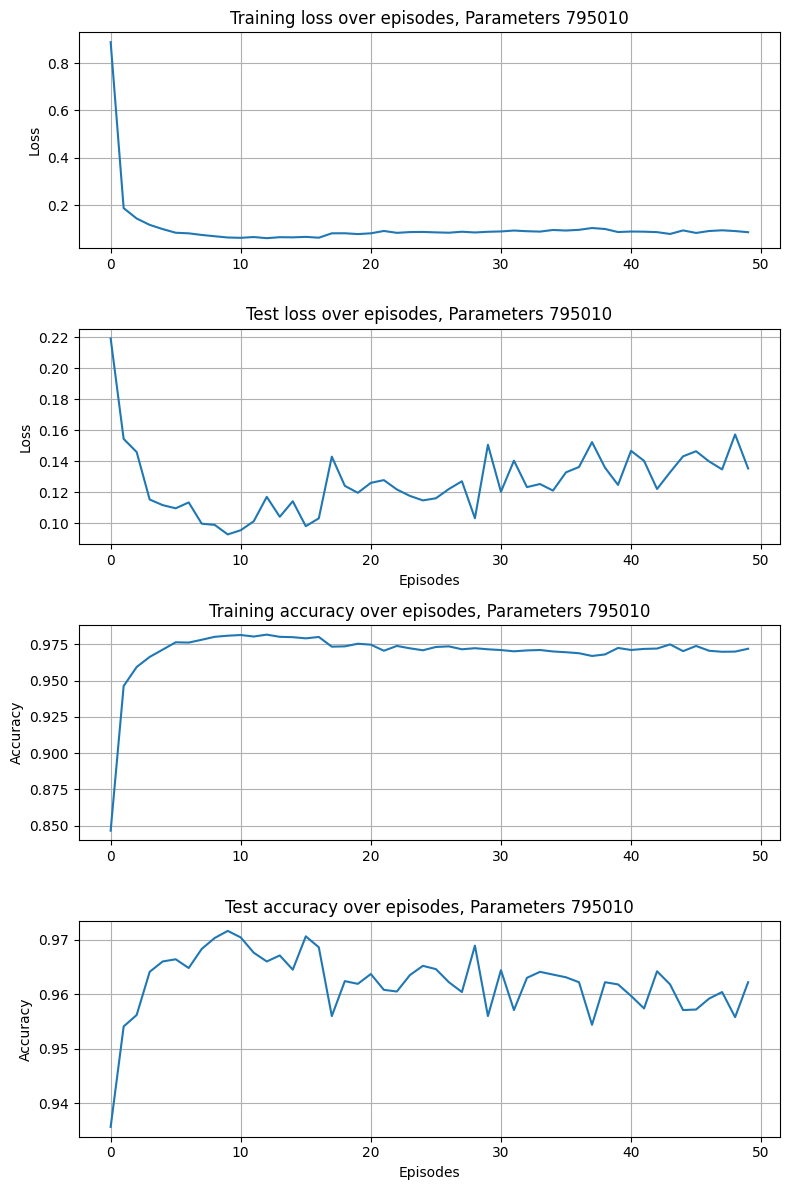

In [42]:
train_loss_mean_nn22 = []
test_loss_mean_nn22 = []
train_acc_mean_nn22 = []
test_acc_mean_nn22 = []
train_loss_mean_nn22, test_loss_mean_nn22, train_acc_mean_nn22, test_acc_mean_nn22 = NN_train_test(train_loader, test_loader, train_loss_mean_nn22, test_loss_mean_nn22, train_acc_mean_nn22, test_acc_mean_nn22, networks[1],"ADAM")
print('train_loss: {}\n test_loss: {}\n train_acc: {}\n test_acc: {}'.format(train_loss_mean_nn22,test_loss_mean_nn22,train_acc_mean_nn22, test_acc_mean_nn22))
plot_loss(train_loss_mean_nn22,test_loss_mean_nn22,train_acc_mean_nn22, test_acc_mean_nn22, parameters(networks[1]))

# NN3 - Convolution, optim = SGD

SGD optim
0 8.20, 1 7.95, 2 8.13, 3 8.36, 4 8.03, 5 8.03, 6 8.02, 7 8.35, 8 7.95, 9 8.11, 10 8.77, 11 8.19, 12 8.19, 13 8.05, 14 8.34, 15 7.90, 16 8.03, 17 8.03, 18 8.30, 19 7.93, 20 7.92, 21 7.97, 22 8.37, 23 7.94, 24 7.89, 25 7.94, 26 8.29, 27 7.90, 28 8.04, 29 7.85, 30 8.32, 31 7.99, 32 8.19, 33 7.95, 34 8.25, 35 7.97, 36 7.90, 37 7.94, 38 8.34, 39 7.85, 40 8.09, 41 7.92, 42 8.42, 43 7.84, 44 8.03, 45 8.25, 46 7.90, 47 8.00, 48 7.98, 49 8.28, train_loss: [0.6559971235692501, 0.19486106882492701, 0.13826195963968832, 0.10660995865861575, 0.08971692174673081, 0.07546338755637408, 0.06735686113437017, 0.060466111699740095, 0.051280833998074135, 0.04748183282402654, 0.041312258085235955, 0.043096329116572935, 0.034011271145815654, 0.02984184691061576, 0.029024102670761446, 0.02883777245879173, 0.023293091775849463, 0.02073010189536338, 0.01889160939802726, 0.01761747625035544, 0.015795988721462588, 0.014603665727190674, 0.01311750808575501, 0.011069635649134095, 0.01051945779278564, 0.0

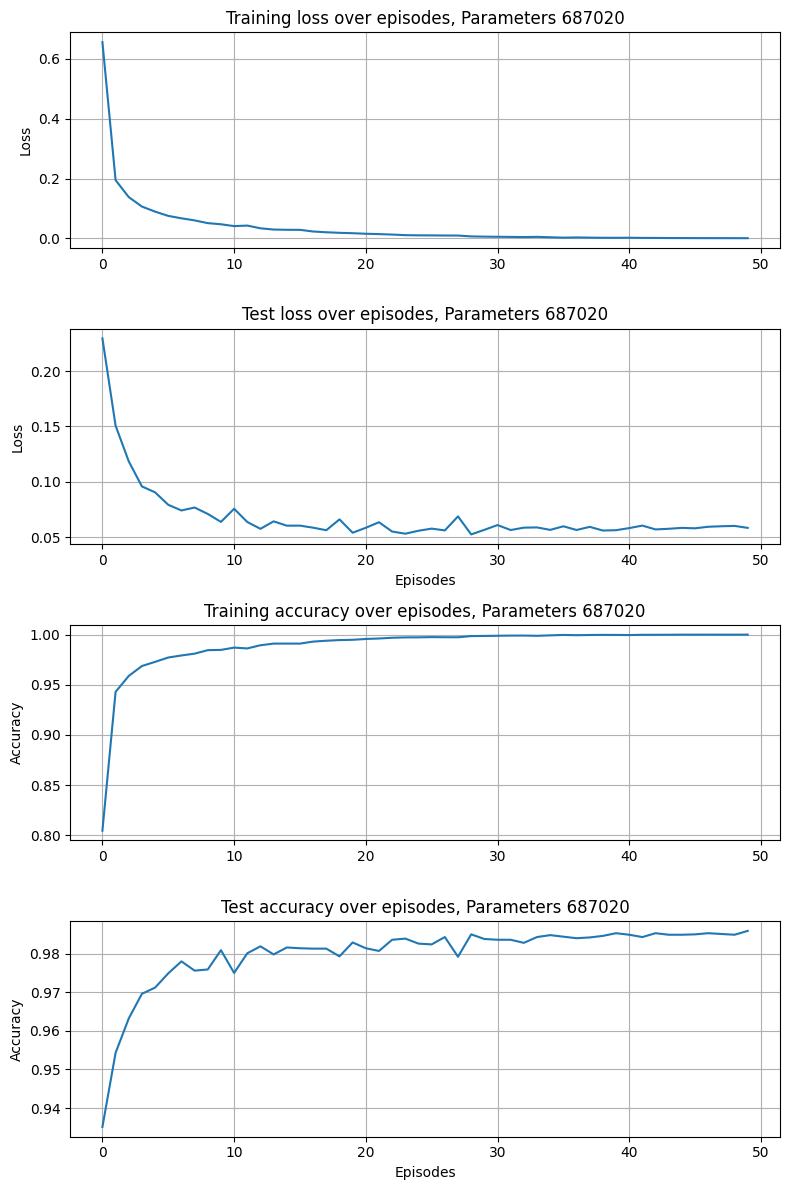

In [43]:
train_loss_mean_nn3 = []
test_loss_mean_nn3 = []
train_acc_mean_nn3 = []
test_acc_mean_nn3 = []
train_loss_mean_nn3, test_loss_mean_nn3, train_acc_mean_nn3, test_acc_mean_nn3 = NN_train_test(train_loader, test_loader, train_loss_mean_nn3, test_loss_mean_nn3, train_acc_mean_nn3, test_acc_mean_nn3, networks[2],"SGD")
print('train_loss: {}\n test_loss: {}\n train_acc: {}\n test_acc: {}'.format(train_loss_mean_nn3,test_loss_mean_nn3,train_acc_mean_nn3, test_acc_mean_nn3))
plot_loss(train_loss_mean_nn3,test_loss_mean_nn3,train_acc_mean_nn3, test_acc_mean_nn3, parameters(networks[2]))

# NN3 - Convolution, optim = ADAM

Adam optim
0 7.89, 1 8.14, 2 8.10, 3 8.24, 4 8.05, 5 7.95, 6 7.81, 7 8.23, 8 7.86, 9 7.93, 10 7.79, 11 8.18, 12 8.08, 13 7.98, 14 7.88, 15 8.22, 16 7.91, 17 7.95, 18 8.07, 19 8.40, 20 8.17, 21 7.84, 22 8.14, 23 8.27, 24 8.05, 25 7.88, 26 7.94, 27 8.48, 28 8.02, 29 8.03, 30 7.93, 31 8.32, 32 8.12, 33 7.97, 34 8.51, 35 8.11, 36 7.98, 37 8.03, 38 8.33, 39 8.07, 40 8.17, 41 8.03, 42 8.50, 43 8.08, 44 8.02, 45 8.04, 46 8.22, 47 8.12, 48 7.93, 49 8.07, train_loss: [13.505760411041168, 0.24208338893949985, 0.18927773709098497, 0.1686238250384728, 0.15326821766793727, 0.14014785209049782, 0.13370598970601957, 0.12505177228401104, 0.12037426133950552, 0.12079604535053173, 0.11384262700254719, 0.11168816927820444, 0.11294888729850451, 0.11061161160469055, 0.10473311621074875, 0.10414501307532191, 0.10380096711839239, 0.10984272599841158, 0.1075490832949678, 0.10531342281028629, 0.10292928889393807, 0.10234903463472923, 0.10128981228917837, 0.10130231557413935, 0.09747638171538711, 0.097839617263

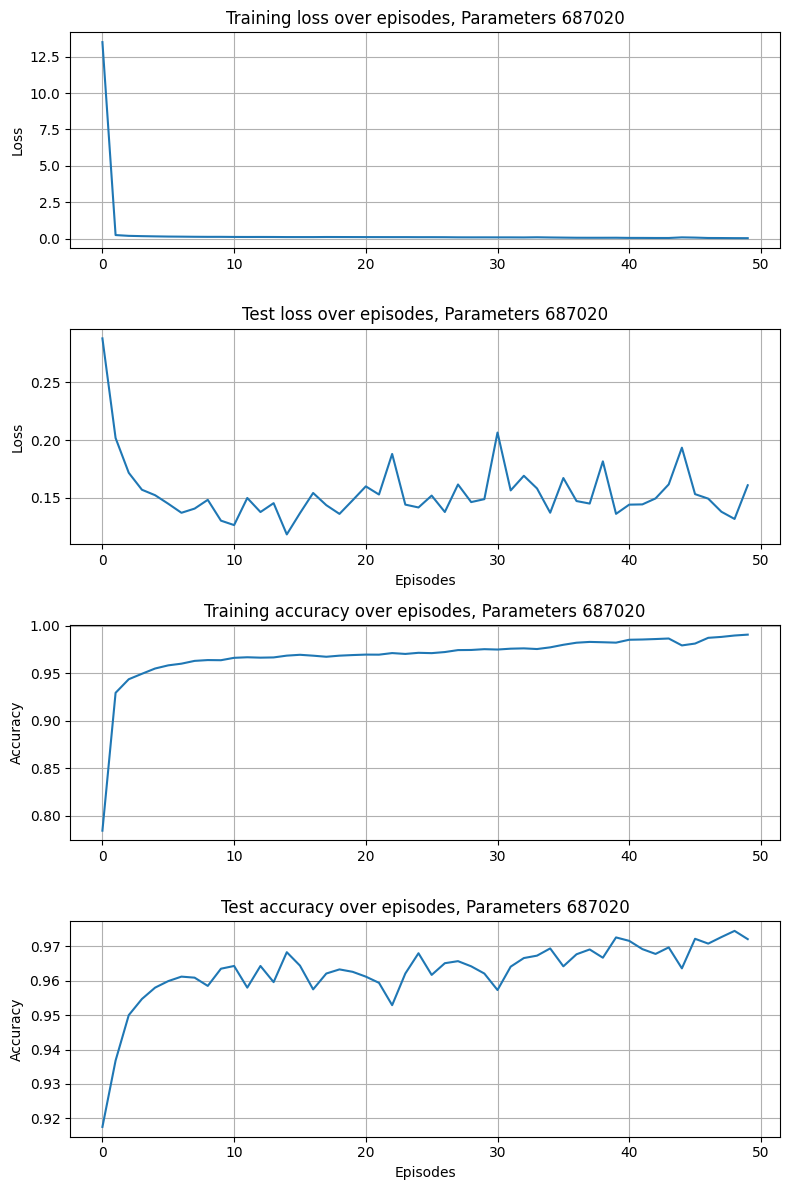

In [44]:
train_loss_mean_nn32 = []
test_loss_mean_nn32 = []
train_acc_mean_nn32 = []
test_acc_mean_nn32 = []
train_loss_mean_nn32, test_loss_mean_nn32, train_acc_mean_nn32, test_acc_mean_nn32 = NN_train_test(train_loader, test_loader, train_loss_mean_nn32, test_loss_mean_nn32, train_acc_mean_nn32, test_acc_mean_nn32, networks[2],"ADAM")
print('train_loss: {}\n test_loss: {}\n train_acc: {}\n test_acc: {}'.format(train_loss_mean_nn32,test_loss_mean_nn32,train_acc_mean_nn32, test_acc_mean_nn32))
plot_loss(train_loss_mean_nn32,test_loss_mean_nn32,train_acc_mean_nn32, test_acc_mean_nn32, parameters(networks[2]))

# NN4 - Convolution + Max Pooling, Optim = SGD

SGD optim
0 8.53, 1 8.05, 2 7.99, 3 7.80, 4 8.28, 5 7.95, 6 8.02, 7 7.99, 8 8.37, 9 8.00, 10 7.97, 11 8.15, 12 8.35, 13 7.91, 14 8.18, 15 8.31, 16 8.09, 17 7.98, 18 7.87, 19 8.22, 20 7.97, 21 8.11, 22 8.03, 23 8.38, 24 7.90, 25 7.94, 26 7.84, 27 8.32, 28 8.06, 29 7.92, 30 7.90, 31 8.44, 32 7.98, 33 7.92, 34 7.85, 35 8.02, 36 7.71, 37 7.80, 38 7.62, 39 8.03, 40 7.70, 41 7.74, 42 7.90, 43 8.22, 44 7.80, 45 7.73, 46 7.70, 47 8.05, 48 7.82, 49 7.69, train_loss: [0.7078095917900403, 0.19917586812128624, 0.14015051759779454, 0.10909649605552356, 0.09222806707645456, 0.07854027403518557, 0.0672419164640208, 0.058278526303668816, 0.052549271114791435, 0.046445350830132764, 0.03976374558794002, 0.03635989980927358, 0.03186966861442973, 0.029386936710216104, 0.02722590377088636, 0.022493785763314615, 0.02068802996072918, 0.017976356123108418, 0.01526994384281958, 0.014389642545332511, 0.012865686517519256, 0.010792575006295617, 0.009230640084327509, 0.007869004431025435, 0.007280844872972618, 0.

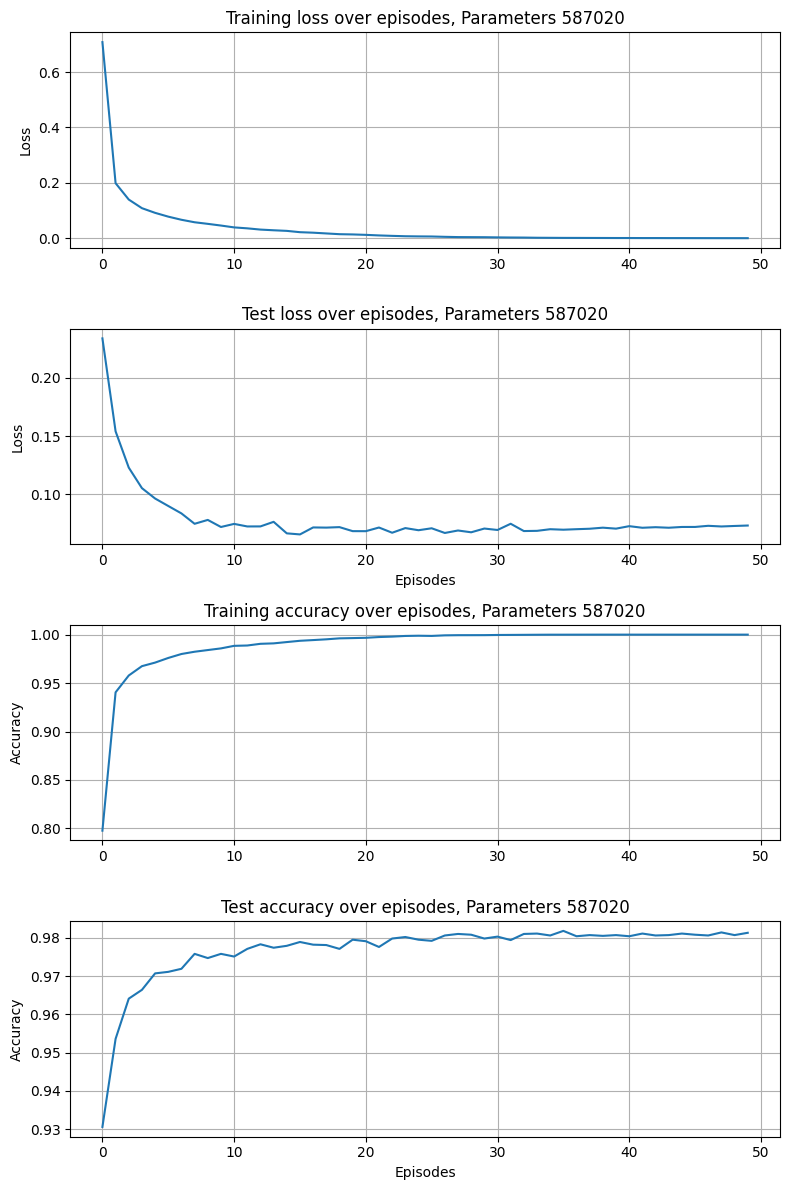

In [45]:
train_loss_mean_nn4 = []
test_loss_mean_nn4 = []
train_acc_mean_nn4 = []
test_acc_mean_nn4 = []
train_loss_mean_nn4, test_loss_mean_nn4, train_acc_mean_nn4, test_acc_mean_nn4 = NN_train_test(train_loader, test_loader, train_loss_mean_nn4, test_loss_mean_nn4, train_acc_mean_nn4, test_acc_mean_nn4, networks[3],"SGD")
print('train_loss: {}\n test_loss: {}\n train_acc: {}\n test_acc: {}'.format(train_loss_mean_nn4,test_loss_mean_nn4,train_acc_mean_nn4, test_acc_mean_nn4))
plot_loss(train_loss_mean_nn4,test_loss_mean_nn4,train_acc_mean_nn4, test_acc_mean_nn4, parameters(networks[3]))

# NN4 - Convolution + Max Pooling, Optim = Adam

Adam optim
0 7.71, 1 8.27, 2 8.00, 3 7.63, 4 7.75, 5 7.89, 6 7.78, 7 7.66, 8 7.71, 9 8.03, 10 7.73, 11 7.56, 12 7.69, 13 8.19, 14 7.70, 15 7.72, 16 7.75, 17 8.01, 18 7.76, 19 7.73, 20 7.72, 21 7.84, 22 7.72, 23 7.85, 24 7.76, 25 8.15, 26 7.73, 27 7.75, 28 7.97, 29 8.00, 30 7.71, 31 7.76, 32 7.94, 33 8.21, 34 7.71, 35 7.73, 36 7.85, 37 8.09, 38 7.79, 39 7.73, 40 7.90, 41 8.00, 42 7.70, 43 7.74, 44 7.81, 45 7.95, 46 7.57, 47 7.70, 48 7.78, 49 8.01, train_loss: [6.991472414144179, 0.21189298921575148, 0.1559199085459113, 0.1342314802731077, 0.11904150104771058, 0.1086759431908528, 0.09911633025233944, 0.09501889726767937, 0.09524659396459659, 0.08733298958589633, 0.08439957561592261, 0.08470491506159306, 0.07991349464282393, 0.07928310884162784, 0.07504462778257827, 0.09812074506965776, 0.09062774702906609, 0.09445627018188436, 0.08250553634328146, 0.09608175077786048, 0.08879105954741438, 0.08321327832527459, 0.07956011436569194, 0.08102092263288796, 0.08312424966134131, 0.09566065824280

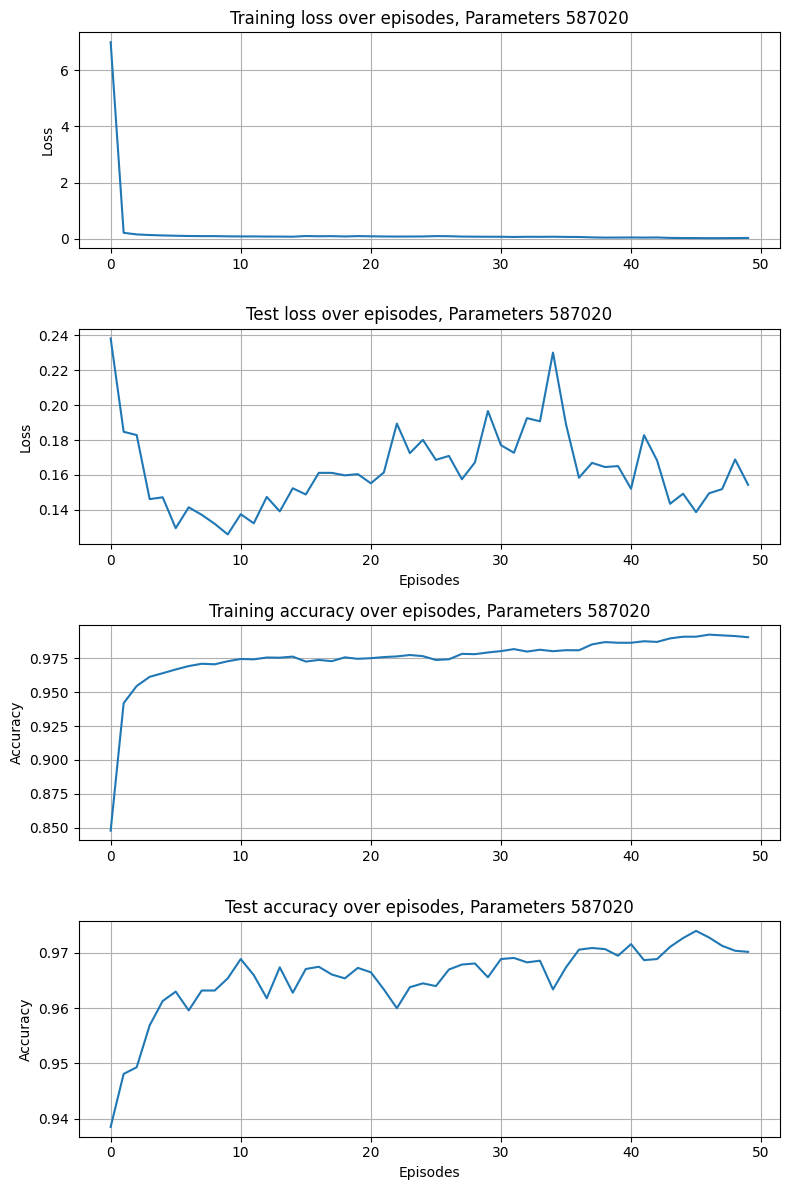

In [46]:
train_loss_mean_nn42 = []
test_loss_mean_nn42 = []
train_acc_mean_nn42 = []
test_acc_mean_nn42 = []
train_loss_mean_nn42, test_loss_mean_nn42, train_acc_mean_nn42, test_acc_mean_nn42 = NN_train_test(train_loader, test_loader, train_loss_mean_nn42, test_loss_mean_nn42, train_acc_mean_nn42, test_acc_mean_nn42, networks[3],"ADAM")
print('train_loss: {}\n test_loss: {}\n train_acc: {}\n test_acc: {}'.format(train_loss_mean_nn42,test_loss_mean_nn42,train_acc_mean_nn42, test_acc_mean_nn42))
plot_loss(train_loss_mean_nn42,test_loss_mean_nn42,train_acc_mean_nn42, test_acc_mean_nn42, parameters(networks[3]))

Losses with SGD Optimizer

In [12]:
import matplotlib.pyplot as plt

def get_label(i,num_parameters,optim):
  if i == 0:
    return f" Relu + {optim} optim - Parameters {num_parameters[i]}"
  if i == 1:
    return f"Sigmoid + {optim} optim - Parameters {num_parameters[i]}"
  if i == 2:
    return f"Conv + {optim} optim - Parameters {num_parameters[i]}"
  if i == 3:
    return f"Conv + MP+ {optim} optim - Parameters {num_parameters[i]}"   

def plot_loss_NNs(train_losses, test_losses, num_params,optim):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 8))
    for i in range(len(train_losses)):
        ax1.plot(train_losses[i], label=get_label(i,num_params,optim))
        ax2.plot(test_losses[i], label=get_label(i,num_params,optim))

    ax1.set_title("Training loss over episodes")
    ax1.set_ylabel("Loss")
    ax1.grid()

    ax2.set_title("Test loss over episodes")
    ax2.set_ylabel("Loss")
    ax2.set_xlabel("Episodes")
    ax2.grid()

    ax1.legend()
    ax2.legend()

# Cumulative graphs

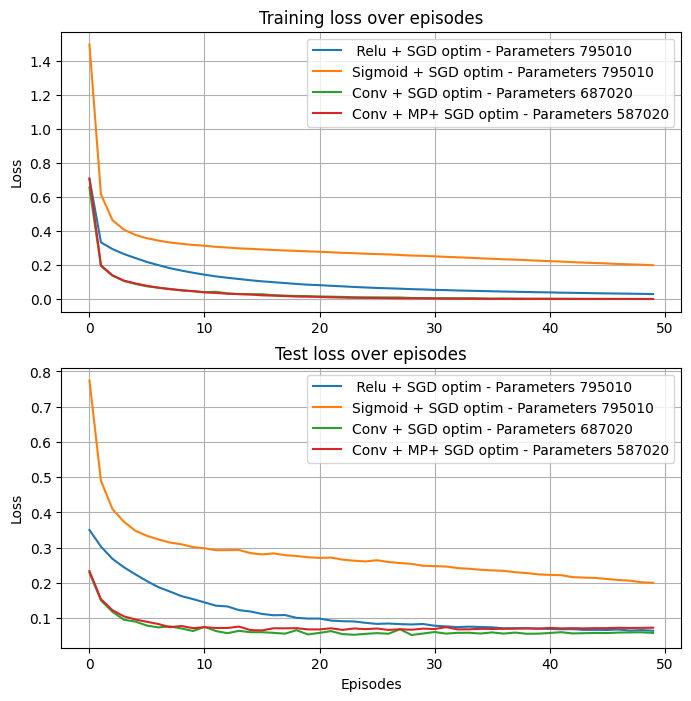

In [48]:


plot_loss_NNs([train_loss_mean_nn1, train_loss_mean_nn2, train_loss_mean_nn3, train_loss_mean_nn4],
          [test_loss_mean_nn1, test_loss_mean_nn2, test_loss_mean_nn3, test_loss_mean_nn4],
          [parameters(networks[0]), parameters(networks[1]), parameters(networks[2]), parameters(networks[3])],"SGD")


In [13]:
import matplotlib.pyplot as plt

def plot_acc_NNs(train_losses, test_losses, num_params, optim):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 8))
    for i in range(len(train_losses)):
        ax1.plot(train_losses[i], label = get_label(i,num_params,optim))
        ax2.plot(test_losses[i], label = get_label(i,num_params,optim))

    ax1.set_title("Training Accuracy over episodes")
    ax1.set_ylabel("Accuracy")
    ax1.grid()

    ax2.set_title("Test Accuracy over episodes")
    ax2.set_ylabel("Accuracy")
    ax2.set_xlabel("Episodes")
    ax2.grid()

    ax1.legend()
    ax2.legend()

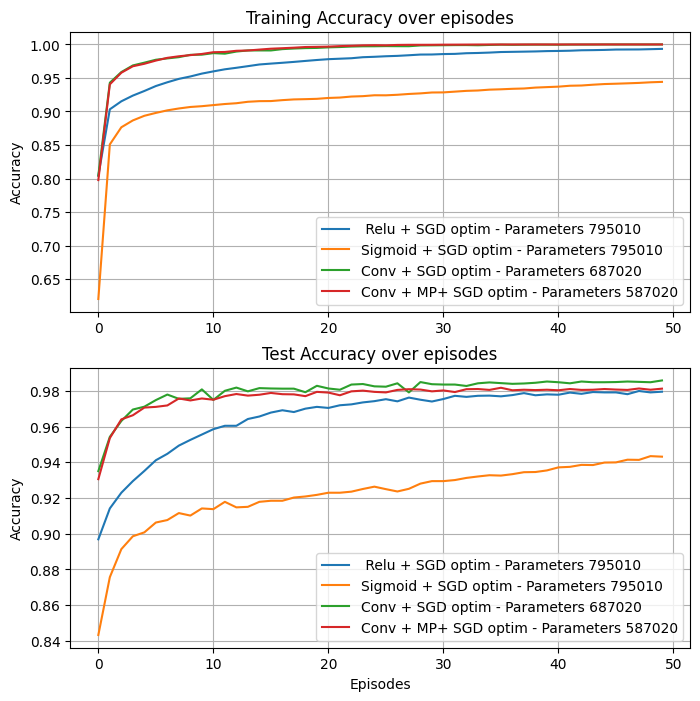

In [52]:


plot_acc_NNs([train_acc_mean_nn1, train_acc_mean_nn2, train_acc_mean_nn3, train_acc_mean_nn4],
          [test_acc_mean_nn1, test_acc_mean_nn2, test_acc_mean_nn3, test_acc_mean_nn4],
          [parameters(networks[0]), parameters(networks[1]), parameters(networks[2]), parameters(networks[3])],"SGD")


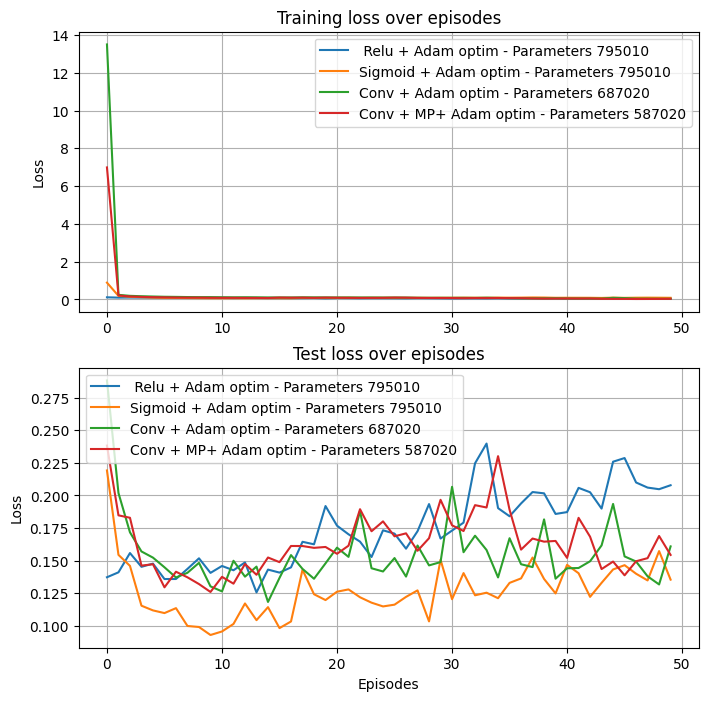

In [53]:


plot_loss_NNs([train_loss_mean_nn12, train_loss_mean_nn22, train_loss_mean_nn32, train_loss_mean_nn42],
          [test_loss_mean_nn12, test_loss_mean_nn22, test_loss_mean_nn32, test_loss_mean_nn42],
          [parameters(networks[0]), parameters(networks[1]), parameters(networks[2]), parameters(networks[3])],"Adam")


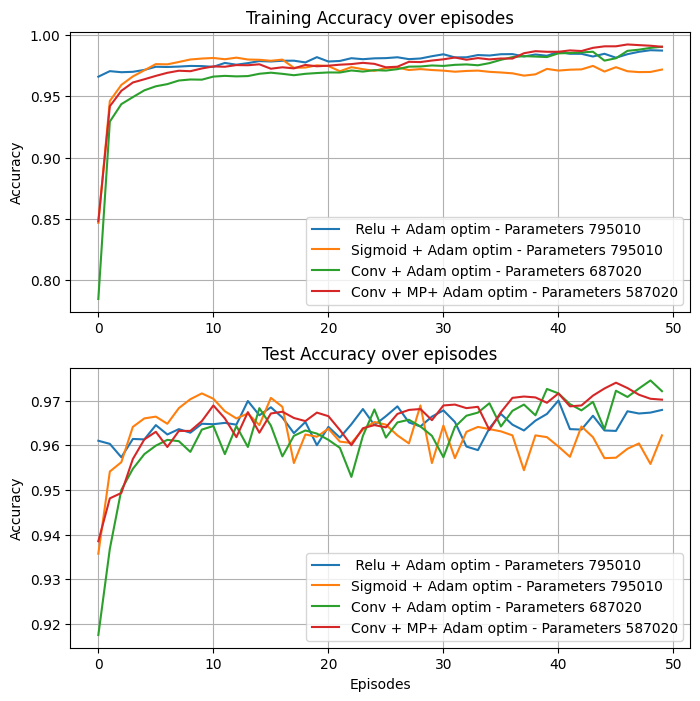

In [54]:


plot_acc_NNs([train_acc_mean_nn12, train_acc_mean_nn22, train_acc_mean_nn32, train_acc_mean_nn42],
          [test_acc_mean_nn12, test_acc_mean_nn22, test_acc_mean_nn32, test_acc_mean_nn42],
          [parameters(networks[0]), parameters(networks[1]), parameters(networks[2]), parameters(networks[3])],"Adam")


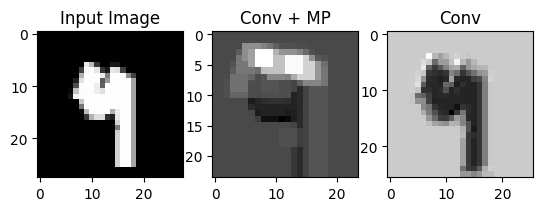

In [55]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class CNN_mp(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=1, padding=0)

    def forward(self, f_hat):
        f_hat = self.conv1(f_hat)
        f_hat = self.pool(f_hat)
        return f_hat

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0)

    def forward(self, f_hat):
        f_hat = self.conv1(f_hat)
        return f_hat


# Get a batch of data
input, targets = next(iter(train_loader))
input_image = input.reshape(-1, 1, 28, 28)  # Reshape to [batch_size, 1, 28, 28]

# Perform forward pass
output_max = CNN_mp()(input_image)
output_conv = CNN()(input_image)


# Plot the input image
plt.subplot(1, 3, 1)
plt.imshow(input_image[0][0].numpy(), cmap='gray')
plt.title('Input Image')

# Plot the output of the convolutional layer or convolution+max-pool layers
plt.subplot(1, 3, 2)
plt.imshow(output_max[0][0].detach().numpy(), cmap='gray')
plt.title('Conv + MP')

# Plot the output of the convolutional layer or convolution+max-pool layers
plt.subplot(1, 3, 3)
plt.imshow(output_conv[0][0].detach().numpy(), cmap='gray')
plt.title('Conv')

plt.show()


# TASK 1.3 Permuted DataSet

5
60000
torch.Size([1, 28, 28])


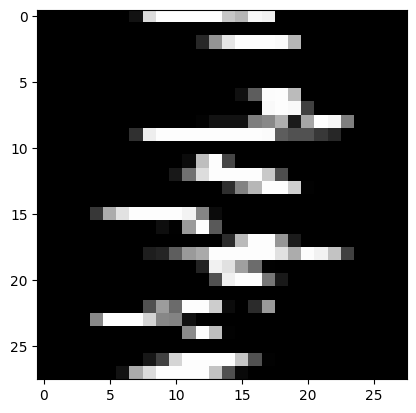

In [6]:
torch.manual_seed(124532)
np.random.seed(124532)

#permutation function
def permute_pixels(x):
    # Permute each channel separately
    for i in range(x.size(0)):
        x[i] = x[i][torch.randperm(x[i].size(0))]
    return x

#Resizing the image size from 32x32x3 to 112x112x3
#conversion to tensor
#Normalizing
#then permutating the image pixels
transform_permuted = Compose(
    [ToTensor(),
     Normalize(mean=[0.5], std=[0.5]),
     Lambda(permute_pixels) # applying permutation
     ])


# Download the MNIST dataset
train_data_permuted = MNIST(root='./data', train=True, download=True, transform=transform_permuted)
test_data_permuted = MNIST(root='./data', train=False, download=True, transform=transform_permuted)

plt.imshow(train_data_permuted[0][0].reshape(28,28),cmap='gray')
print(train_data_permuted[0][1])
print(len(train_data_permuted))
print(train_data_permuted[0][0].shape)

# Data loaders
batch_size = 500  # Define your batch size
train_loader_permuted = DataLoader(train_data_permuted, batch_size=batch_size, shuffle=True,num_workers=2)
test_loader_permuted = DataLoader(test_data_permuted, batch_size=batch_size, shuffle=False,num_workers=2)

# NN1 Perm - ReLu, Optim = SGD

SGD optim
0 11.59, 1 10.76, 2 10.72, 3 11.07, 4 10.94, 5 10.87, 6 11.25, 7 10.86, 8 10.88, 9 11.15, 10 10.79, 11 10.80, 12 11.20, 13 10.74, 14 10.98, 15 11.48, 16 10.88, 17 11.22, 18 10.84, 19 10.75, 20 11.10, 21 10.95, 22 10.70, 23 11.04, 24 10.77, 25 10.87, 26 11.08, 27 10.71, 28 10.72, 29 11.06, 30 10.85, 31 10.79, 32 11.20, 33 10.65, 34 10.81, 35 11.09, 36 10.90, 37 10.96, 38 11.24, 39 10.75, 40 10.79, 41 11.25, 42 10.72, 43 10.96, 44 11.02, 45 10.87, 46 11.21, 47 10.73, 48 10.89, 49 11.02, train_loss: [1.8828578193982441, 1.7048856755097708, 1.6756276577711104, 1.6369591852029164, 1.596288471420606, 1.5517409185568491, 1.507929457227389, 1.4697509318590165, 1.4309500247240066, 1.3937307784954707, 1.3618080814679463, 1.3291240990161897, 1.293636617064476, 1.2618992378314335, 1.2237887680530548, 1.2006201773881913, 1.1653362820545832, 1.1341413855552673, 1.103588910897573, 1.0782098109523455, 1.056784057120482, 1.030372367799282, 1.010259107251962, 0.9951642990112305, 0.967373691002

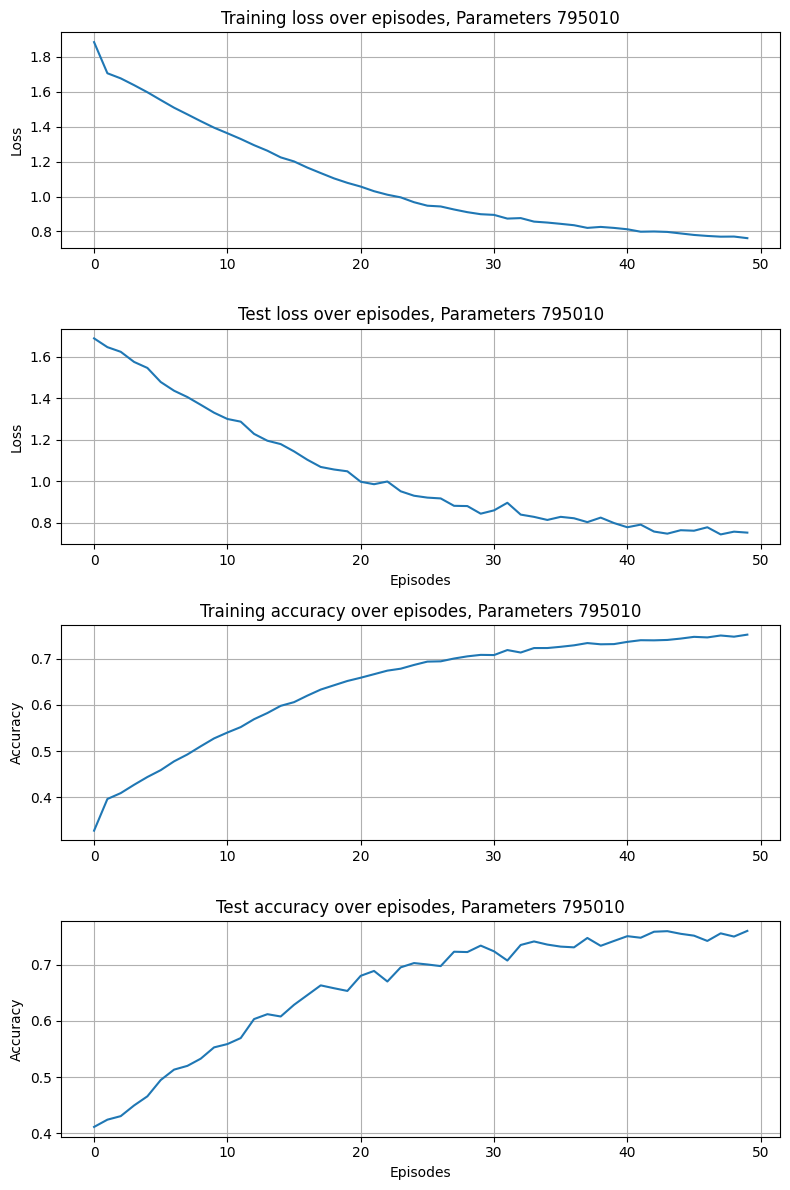

In [7]:
# Training loop NN_1
train_loss_mean_perm_nn1 = []
test_loss_mean_perm_nn1 = []
train_acc_mean_perm_nn1 = []
test_acc_mean_perm_nn1 = []
train_loss_mean_perm_nn1, test_loss_mean_perm_nn1, train_acc_mean_perm_nn1, test_acc_mean_perm_nn1 = NN_train_test(train_loader_permuted, test_loader_permuted, train_loss_mean_perm_nn1, test_loss_mean_perm_nn1, train_acc_mean_perm_nn1, test_acc_mean_perm_nn1, networks[0],"SGD")
print('train_loss: {}\n test_loss: {}\n train_acc: {}\n test_acc: {}'.format(train_loss_mean_perm_nn1,test_loss_mean_perm_nn1,train_acc_mean_perm_nn1, test_acc_mean_perm_nn1))
plot_loss(train_loss_mean_perm_nn1,test_loss_mean_perm_nn1,train_acc_mean_perm_nn1, test_acc_mean_perm_nn1, parameters(networks[0]))

# NN2 Perm - Sigmoid, Optim = SGD

SGD optim
0 10.88, 1 10.79, 2 11.18, 3 10.80, 4 10.84, 5 11.09, 6 10.88, 7 10.98, 8 10.95, 9 10.88, 10 10.71, 11 11.19, 12 10.74, 13 10.80, 14 11.21, 15 10.88, 16 10.83, 17 11.35, 18 10.87, 19 10.94, 20 11.30, 21 10.89, 22 11.20, 23 10.94, 24 10.83, 25 11.10, 26 10.88, 27 10.82, 28 11.30, 29 10.78, 30 10.83, 31 11.33, 32 10.81, 33 10.84, 34 11.21, 35 10.78, 36 10.76, 37 11.23, 38 10.90, 39 10.85, 40 11.26, 41 10.91, 42 10.99, 43 11.19, 44 10.82, 45 11.04, 46 10.86, 47 10.80, 48 11.16, 49 10.74, train_loss: [2.1553407748540243, 1.8788192758957545, 1.770482728878657, 1.7354513416687647, 1.7207076609134675, 1.7110831797122956, 1.707274940609932, 1.7033012201388678, 1.7000537017981212, 1.6962730805079143, 1.6932340413331985, 1.689984138806661, 1.6910451938708624, 1.6839545965194702, 1.68306445479393, 1.6808039893706639, 1.6770676960547766, 1.6748983124891916, 1.6713656961917878, 1.6676344831784566, 1.6656989067792893, 1.6626955538988113, 1.655921036998431, 1.6524698128302893, 1.64762639403

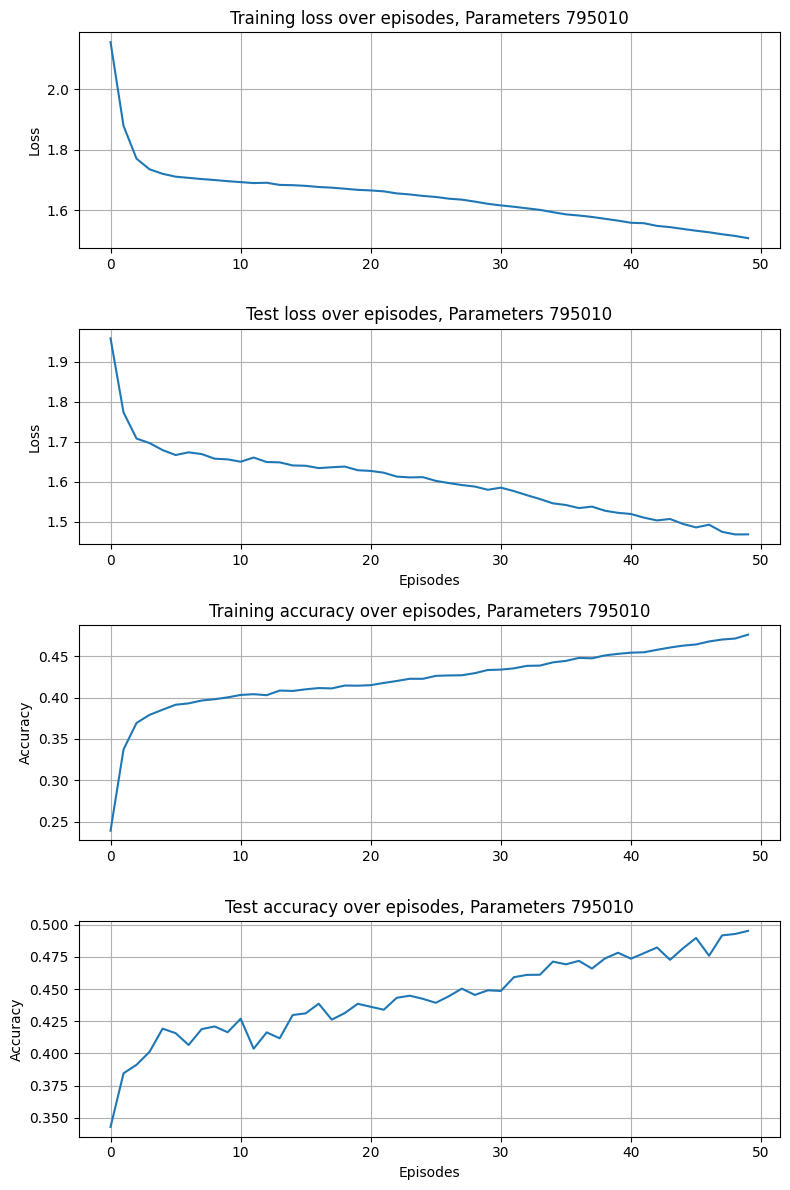

In [8]:
train_loss_mean_perm_nn2 = []
test_loss_mean_perm_nn2 = []
train_acc_mean_perm_nn2 = []
test_acc_mean_perm_nn2 = []
train_loss_mean_perm_nn2, test_loss_mean_perm_nn2, train_acc_mean_perm_nn2, test_acc_mean_perm_nn2 = NN_train_test(train_loader_permuted, test_loader_permuted, train_loss_mean_perm_nn2, test_loss_mean_perm_nn2, train_acc_mean_perm_nn2, test_acc_mean_perm_nn2, networks[1],"SGD")
print('train_loss: {}\n test_loss: {}\n train_acc: {}\n test_acc: {}'.format(train_loss_mean_perm_nn2,test_loss_mean_perm_nn2,train_acc_mean_perm_nn2, test_acc_mean_perm_nn2))
plot_loss(train_loss_mean_perm_nn2,test_loss_mean_perm_nn2,train_acc_mean_perm_nn2, test_acc_mean_perm_nn2, parameters(networks[1]))

# NN3 Perm - Convolution, Optim = SGD

SGD optim
0 12.44, 1 12.02, 2 11.59, 3 11.52, 4 11.89, 5 11.51, 6 11.95, 7 11.50, 8 11.56, 9 11.82, 10 11.45, 11 11.37, 12 11.78, 13 11.52, 14 11.57, 15 11.94, 16 11.49, 17 11.83, 18 11.61, 19 11.49, 20 11.85, 21 11.47, 22 11.56, 23 11.97, 24 11.56, 25 11.96, 26 11.53, 27 11.57, 28 12.01, 29 11.43, 30 11.48, 31 11.86, 32 11.51, 33 11.57, 34 11.81, 35 11.60, 36 11.92, 37 11.44, 38 11.51, 39 11.98, 40 11.47, 41 11.62, 42 11.95, 43 11.57, 44 11.88, 45 11.68, 46 11.47, 47 11.87, 48 11.62, 49 11.54, train_loss: [1.8972291578849156, 1.6472840487957001, 1.5166456242402395, 1.40626759827137, 1.308477783203125, 1.2225634137789407, 1.1412004301945369, 1.083844231069088, 1.0255481585860253, 0.9809128229816755, 0.9451690092682838, 0.9228776251276334, 0.893902617196242, 0.8727125063538551, 0.8614966923991839, 0.8388014609615008, 0.8311808784802754, 0.8243104820450147, 0.8062880908449491, 0.8006442084908485, 0.7826081613699595, 0.7789824669559796, 0.7710646112759908, 0.7593629280726115, 0.7564604798

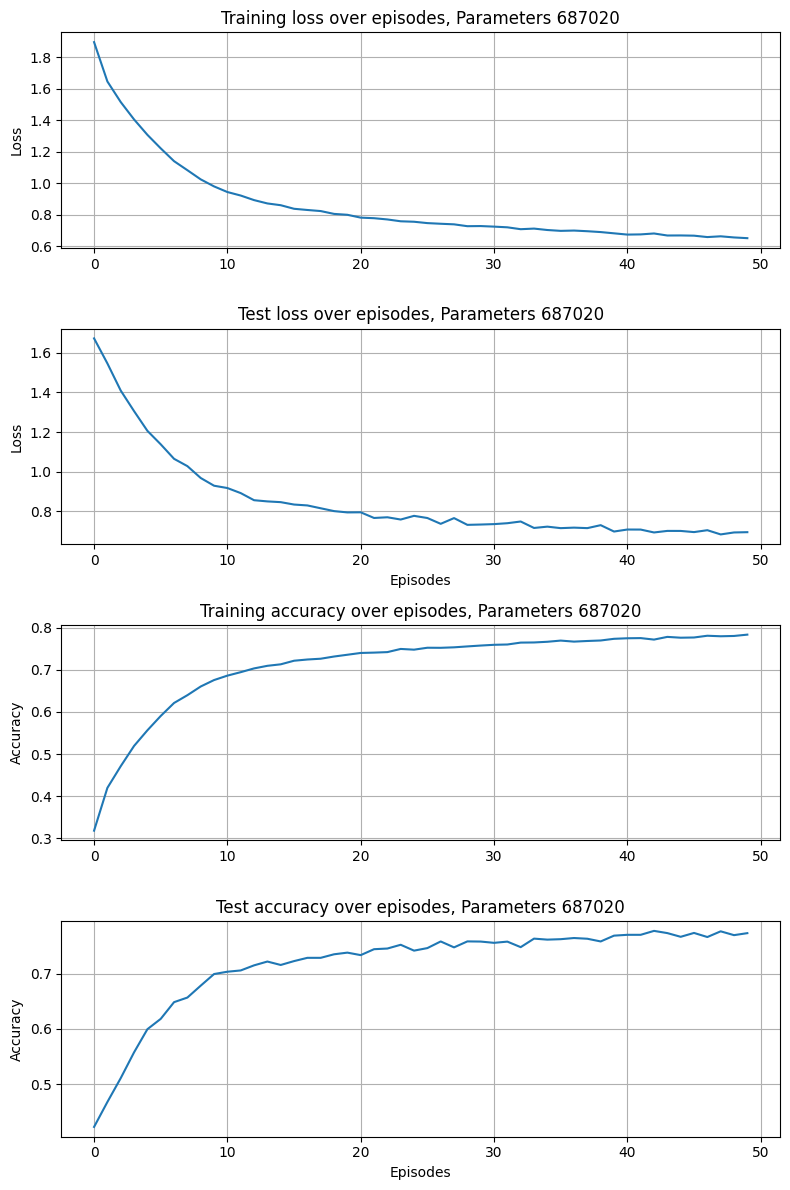

In [9]:
train_loss_mean_perm_nn3 = []
test_loss_mean_perm_nn3 = []
train_acc_mean_perm_nn3 = []
test_acc_mean_perm_nn3 = []
train_loss_mean_perm_nn3, test_loss_mean_perm_nn3, train_acc_mean_perm_nn3, test_acc_mean_perm_nn3 = NN_train_test(train_loader_permuted, test_loader_permuted, train_loss_mean_perm_nn3, test_loss_mean_perm_nn3, train_acc_mean_perm_nn3, test_acc_mean_perm_nn3, networks[2],"SGD")
print('train_loss: {}\n test_loss: {}\n train_acc: {}\n test_acc: {}'.format(train_loss_mean_perm_nn3,test_loss_mean_perm_nn3,train_acc_mean_perm_nn3, test_acc_mean_perm_nn3))
plot_loss(train_loss_mean_perm_nn3,test_loss_mean_perm_nn3,train_acc_mean_perm_nn3, test_acc_mean_perm_nn3, parameters(networks[2]))

# NN4 Perm - Convolution + Max Pooling, Optim = SGD

SGD optim
0 11.47, 1 10.92, 2 11.20, 3 11.22, 4 11.15, 5 11.40, 6 11.00, 7 11.02, 8 11.38, 9 11.08, 10 11.08, 11 11.40, 12 11.00, 13 10.99, 14 11.41, 15 11.25, 16 10.93, 17 11.34, 18 11.03, 19 11.35, 20 11.22, 21 11.20, 22 11.47, 23 10.96, 24 11.00, 25 11.30, 26 11.00, 27 11.07, 28 11.41, 29 11.09, 30 11.01, 31 11.32, 32 11.05, 33 11.12, 34 11.33, 35 11.09, 36 11.37, 37 11.09, 38 11.03, 39 11.31, 40 11.05, 41 11.13, 42 11.37, 43 11.02, 44 11.15, 45 11.31, 46 11.11, 47 10.96, 48 11.46, 49 11.08, train_loss: [1.8209067722161612, 1.4534623811642329, 1.3138694663842518, 1.2302507042884827, 1.1644556830326716, 1.1115682005882264, 1.0736507162451745, 1.0426948234438895, 1.0195342779159546, 0.9951491524775823, 0.9765666916966438, 0.9685848399996757, 0.950890663266182, 0.943611167371273, 0.9239438136418661, 0.9233979791402817, 0.9144127349058787, 0.9042361984650295, 0.9010437101125717, 0.8897858560085297, 0.8860882590214412, 0.8770135621229808, 0.8742474362254142, 0.869118248919646, 0.86399249

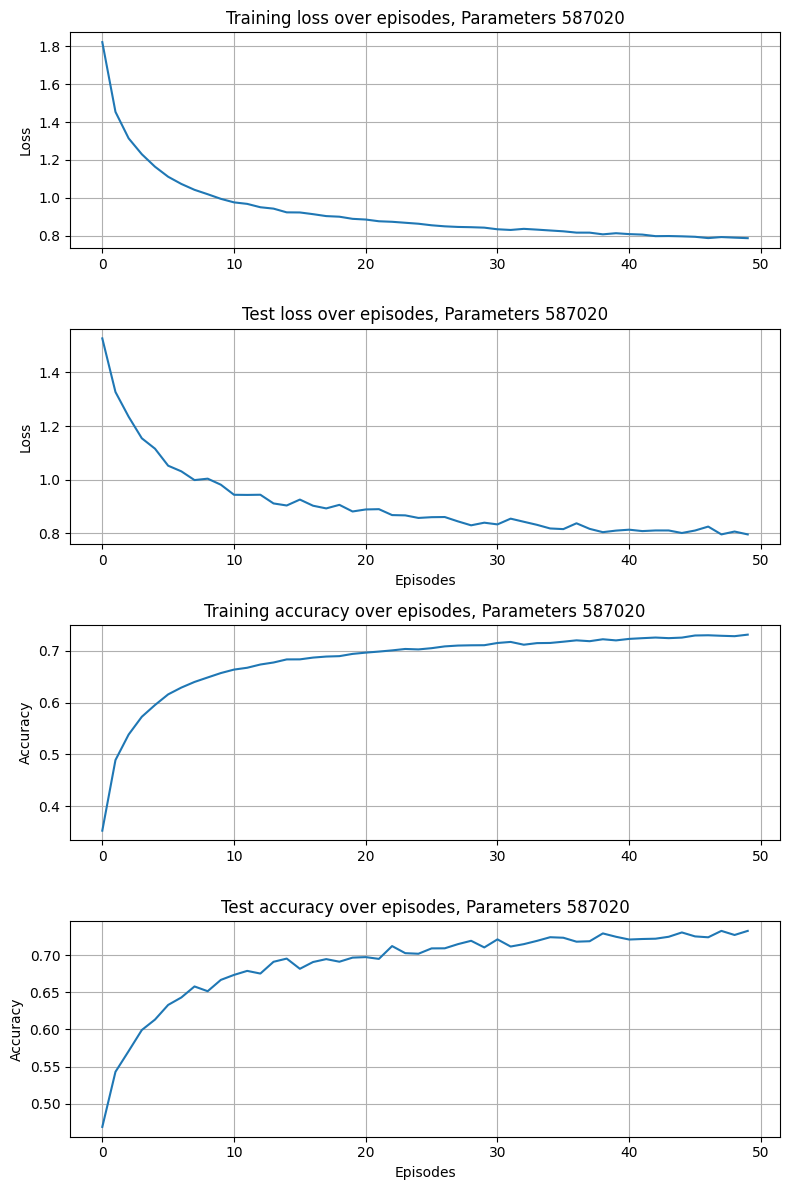

In [10]:
train_loss_mean_perm_nn4 = []
test_loss_mean_perm_nn4 = []
train_acc_mean_perm_nn4 = []
test_acc_mean_perm_nn4 = []
train_loss_mean_perm_nn4, test_loss_mean_perm_nn4, train_acc_mean_perm_nn4, test_acc_mean_perm_nn4 = NN_train_test(train_loader_permuted, test_loader_permuted, train_loss_mean_perm_nn4, test_loss_mean_perm_nn4, train_acc_mean_perm_nn4, test_acc_mean_perm_nn4, networks[3],"SGD")
print('train_loss: {}\n test_loss: {}\n train_acc: {}\n test_acc: {}'.format(train_loss_mean_perm_nn4,test_loss_mean_perm_nn4,train_acc_mean_perm_nn4, test_acc_mean_perm_nn4))
plot_loss(train_loss_mean_perm_nn4,test_loss_mean_perm_nn4,train_acc_mean_perm_nn4, test_acc_mean_perm_nn4, parameters(networks[3]))

# Perm Cumulative graphs

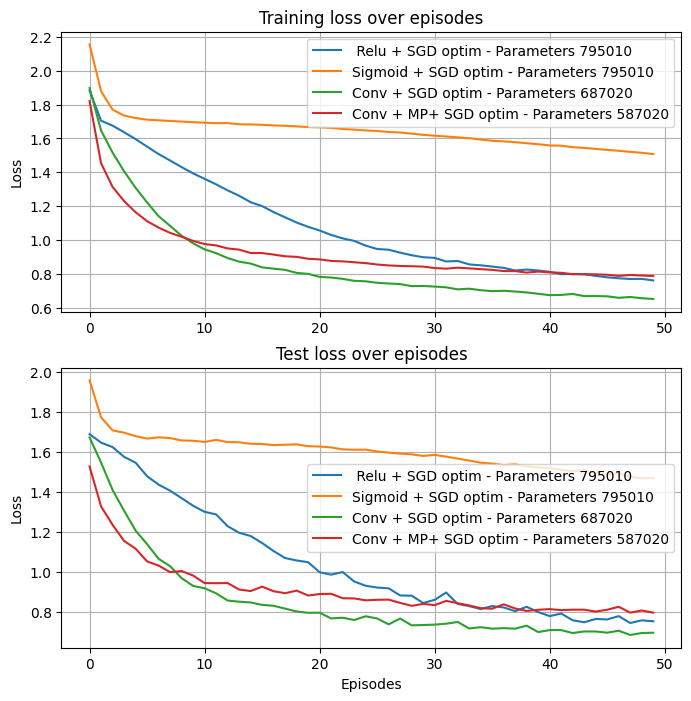

In [14]:
plot_loss_NNs([train_loss_mean_perm_nn1, train_loss_mean_perm_nn2, train_loss_mean_perm_nn3, train_loss_mean_perm_nn4],
          [test_loss_mean_perm_nn1, test_loss_mean_perm_nn2, test_loss_mean_perm_nn3, test_loss_mean_perm_nn4],
          [parameters(networks[0]), parameters(networks[1]), parameters(networks[2]), parameters(networks[3])],"SGD")

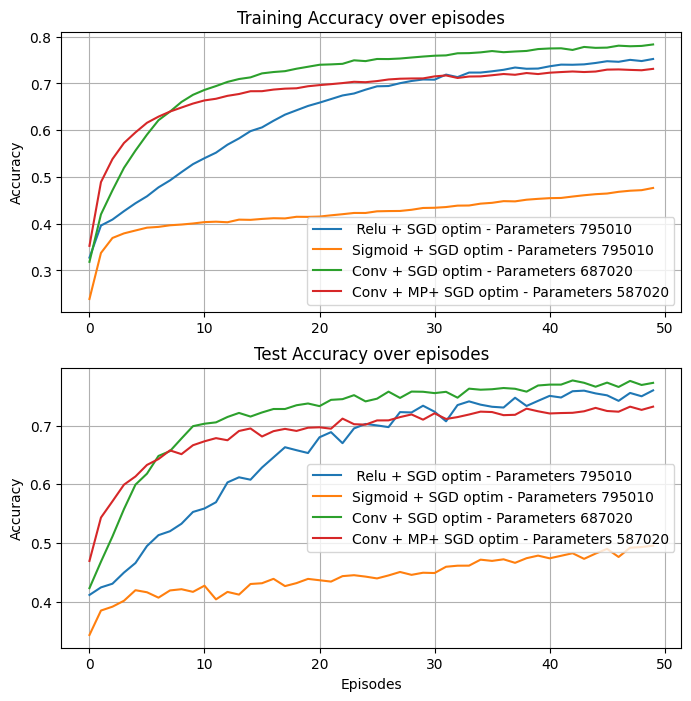

In [15]:
plot_acc_NNs([train_acc_mean_perm_nn1, train_acc_mean_perm_nn2, train_acc_mean_perm_nn3, train_acc_mean_perm_nn4],
          [test_acc_mean_perm_nn1, test_acc_mean_perm_nn2, test_acc_mean_perm_nn3, test_acc_mean_perm_nn4],
          [parameters(networks[0]), parameters(networks[1]), parameters(networks[2]), parameters(networks[3])],"SGD")

# NN1 Perm - ReLu, Optim = ADAM

Adam optim
0 8.82, 1 8.75, 2 9.03, 3 8.65, 4 8.58, 5 8.55, 6 9.08, 7 8.71, 8 8.69, 9 8.63, 10 9.04, 11 8.64, 12 8.63, 13 8.99, 14 8.79, 15 8.70, 16 8.61, 17 9.12, 18 8.70, 19 8.76, 20 9.22, 21 8.73, 22 8.63, 23 8.73, 24 9.09, 25 8.61, 26 8.65, 27 8.57, 28 9.12, 29 8.69, 30 8.62, 31 9.08, 32 8.63, 33 8.67, 34 8.73, 35 9.06, 36 8.52, 37 8.69, 38 9.03, 39 8.74, 40 8.59, 41 8.80, 42 9.06, 43 8.70, 44 8.60, 45 8.65, 46 8.95, 47 8.65, 48 8.69, 49 9.05, train_loss: [5.0770873925338185, 0.23789421233038108, 0.1778404086828232, 0.146790618263185, 0.13115882463753223, 0.1246866044898828, 0.110707697737962, 0.09976009226714572, 0.0957678060978651, 0.09133916879072786, 0.08016249422604839, 0.07643830361776054, 0.07535328827798367, 0.07477135326092442, 0.06681037231658896, 0.06359336986206472, 0.06177627824557324, 0.06205905790751179, 0.058679212971280016, 0.05944599957826237, 0.060881757130846384, 0.053864329836020866, 0.05665543524858852, 0.05825248812325299, 0.04797460553236306, 0.05074297324754

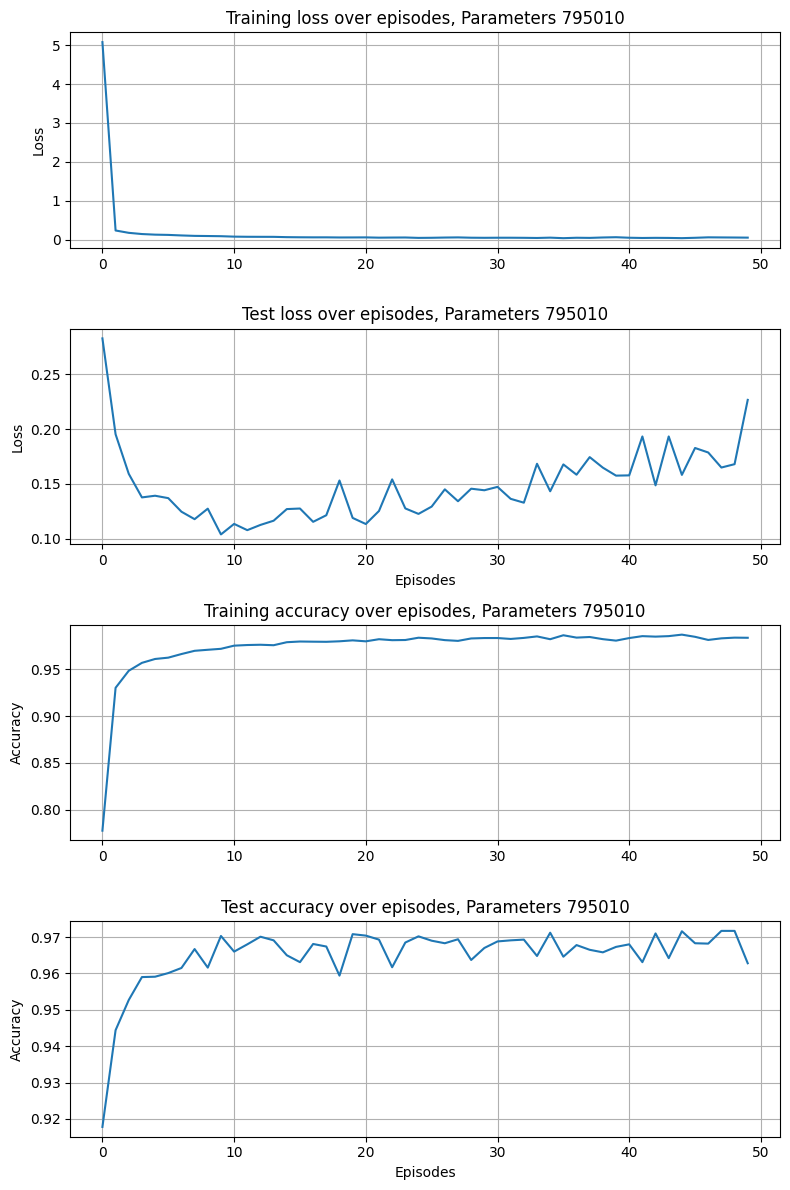

In [16]:
train_loss_mean_perm_nn12 = []
test_loss_mean_perm_nn12 = []
train_acc_mean_perm_nn12 = []
test_acc_mean_perm_nn12 = []
train_loss_mean_perm_nn12, test_loss_mean_perm_nn12, train_acc_mean_perm_nn12, test_acc_mean_perm_nn12 = NN_train_test(train_loader, test_loader, train_loss_mean_perm_nn12, test_loss_mean_perm_nn12, train_acc_mean_perm_nn12, test_acc_mean_perm_nn12, networks[0],"ADAM")
print('train_loss: {}\n test_loss: {}\n train_acc: {}\n test_acc: {}'.format(train_loss_mean_perm_nn12,test_loss_mean_perm_nn12,train_acc_mean_perm_nn12, test_acc_mean_perm_nn12))
plot_loss(train_loss_mean_perm_nn12,test_loss_mean_perm_nn12,train_acc_mean_perm_nn12, test_acc_mean_perm_nn12, parameters(networks[0]))

# NN2 Perm - Sigmoid, Optim = ADAM

Adam optim
0 8.63, 1 8.64, 2 8.69, 3 9.14, 4 8.55, 5 8.69, 6 9.01, 7 8.62, 8 8.66, 9 8.58, 10 9.03, 11 8.61, 12 8.61, 13 8.62, 14 9.01, 15 8.64, 16 8.67, 17 9.06, 18 8.77, 19 8.62, 20 8.71, 21 9.02, 22 8.64, 23 8.68, 24 8.96, 25 8.92, 26 8.78, 27 8.58, 28 8.97, 29 8.74, 30 8.72, 31 8.66, 32 9.06, 33 8.74, 34 8.65, 35 8.97, 36 8.73, 37 8.77, 38 8.70, 39 9.00, 40 8.70, 41 8.80, 42 9.03, 43 8.75, 44 8.67, 45 8.75, 46 9.05, 47 8.77, 48 8.61, 49 8.61, train_loss: [0.8576280088474353, 0.19780366085469722, 0.14001962672919036, 0.11461854744702578, 0.09318499049792688, 0.08176937053600947, 0.07454689163714648, 0.06738329511135817, 0.0615872194369634, 0.06410983748113115, 0.0632358898408711, 0.06368559203110635, 0.06690705285097162, 0.06051215709497531, 0.06601035048564276, 0.07186541905005774, 0.07102860854938627, 0.07287636228526632, 0.08506495114415884, 0.08889481105531255, 0.08622583082566658, 0.08253062566121419, 0.08456136106203, 0.08401935696601867, 0.08153607671459516, 0.088731620460748

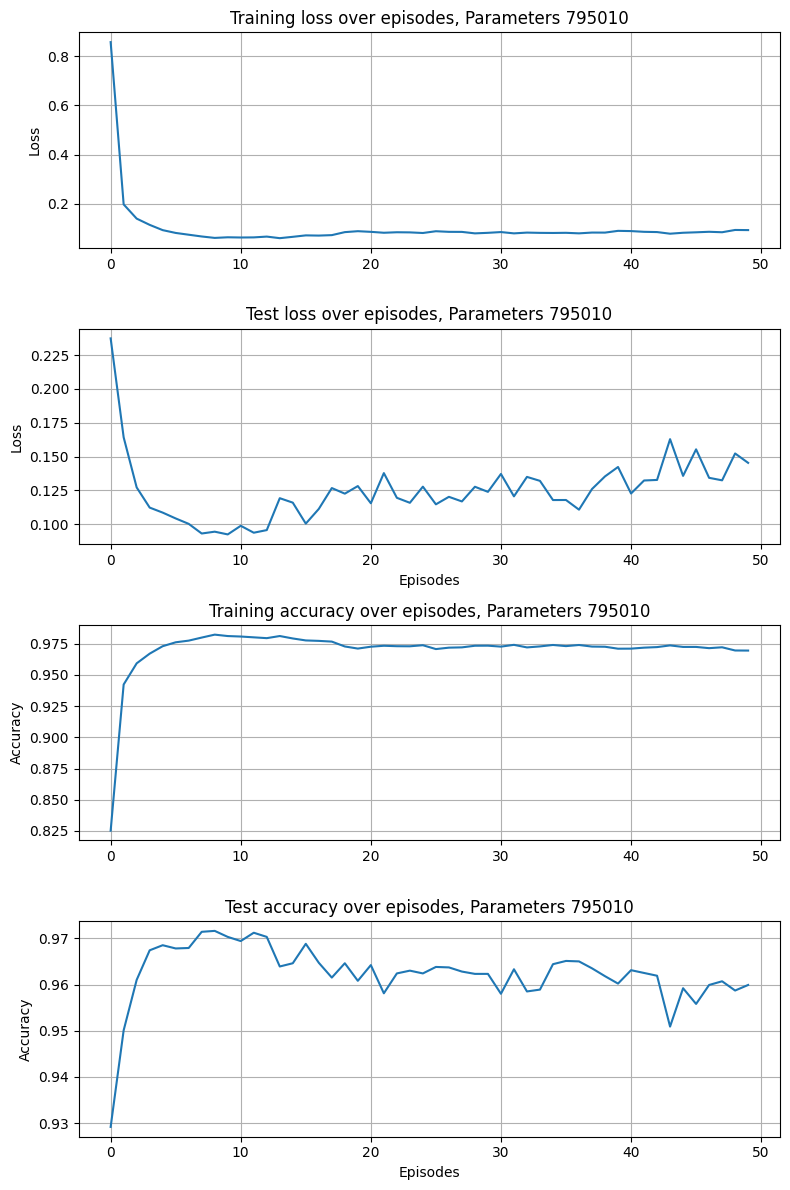

In [17]:
train_loss_mean_perm_nn22 = []
test_loss_mean_perm_nn22 = []
train_acc_mean_perm_nn22 = []
test_acc_mean_perm_nn22 = []
train_loss_mean_perm_nn22, test_loss_mean_perm_nn22, train_acc_mean_perm_nn22, test_acc_mean_perm_nn22 = NN_train_test(train_loader, test_loader, train_loss_mean_perm_nn22, test_loss_mean_perm_nn22, train_acc_mean_perm_nn22, test_acc_mean_perm_nn22, networks[1],"ADAM")
print('train_loss: {}\n test_loss: {}\n train_acc: {}\n test_acc: {}'.format(train_loss_mean_perm_nn22,test_loss_mean_perm_nn22,train_acc_mean_perm_nn22, test_acc_mean_perm_nn22))
plot_loss(train_loss_mean_perm_nn22,test_loss_mean_perm_nn22,train_acc_mean_perm_nn22, test_acc_mean_perm_nn22, parameters(networks[1]))

# NN3 Perm - Convolution, optim = ADAM

Adam optim
0 9.02, 1 8.96, 2 8.84, 3 9.04, 4 8.79, 5 8.73, 6 8.72, 7 9.04, 8 8.71, 9 8.81, 10 9.15, 11 8.71, 12 8.68, 13 8.78, 14 9.18, 15 8.78, 16 8.88, 17 9.26, 18 9.16, 19 8.92, 20 8.90, 21 9.20, 22 8.98, 23 8.81, 24 9.14, 25 8.77, 26 8.83, 27 8.81, 28 9.16, 29 8.70, 30 8.90, 31 9.08, 32 8.82, 33 8.79, 34 8.77, 35 9.24, 36 8.78, 37 8.71, 38 8.87, 39 9.18, 40 8.72, 41 8.77, 42 9.13, 43 8.78, 44 8.77, 45 8.92, 46 9.07, 47 8.75, 48 8.69, 49 9.04, train_loss: [1.7886203040058415, 0.11648453293989101, 0.08367077485503008, 0.07281478022535642, 0.07116593183018267, 0.0597930555852751, 0.07339504010354479, 0.07820355095512545, 0.07765944789474209, 0.0717550007471194, 0.05218061713967472, 0.06176689120087152, 0.07775690748045842, 0.08952414930099621, 0.0916204686043784, 0.09337184666655958, 0.08795526503430058, 0.0931393034174107, 0.08594830134728303, 0.077360462230475, 0.08344290658521156, 0.06972695892521491, 0.05549614334352858, 0.06281938366203879, 0.0599762273998446, 0.07193913904678387

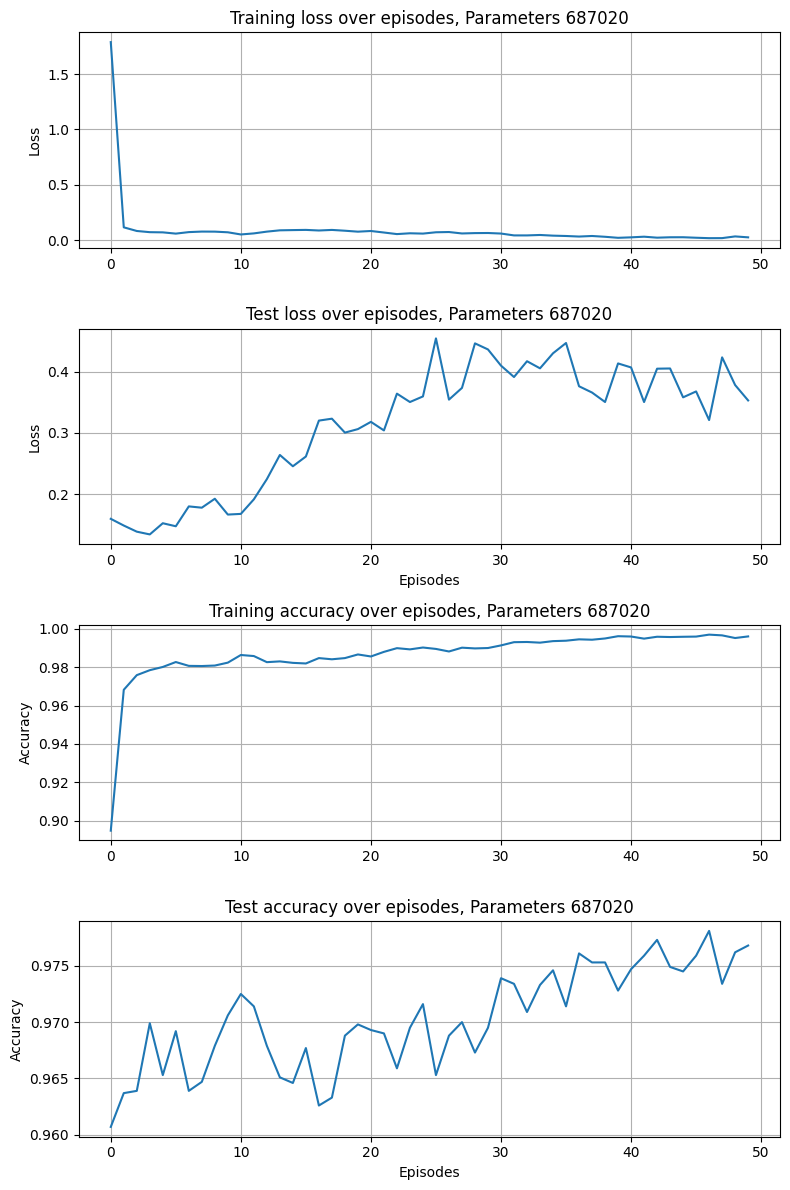

In [18]:
train_loss_mean_perm_nn32 = []
test_loss_mean_perm_nn32 = []
train_acc_mean_perm_nn32 = []
test_acc_mean_perm_nn32 = []
train_loss_mean_perm_nn32, test_loss_mean_perm_nn32, train_acc_mean_perm_nn32, test_acc_mean_perm_nn32 = NN_train_test(train_loader, test_loader, train_loss_mean_perm_nn32, test_loss_mean_perm_nn32, train_acc_mean_perm_nn32, test_acc_mean_perm_nn32, networks[2],"ADAM")
print('train_loss: {}\n test_loss: {}\n train_acc: {}\n test_acc: {}'.format(train_loss_mean_perm_nn32,test_loss_mean_perm_nn32,train_acc_mean_perm_nn32, test_acc_mean_perm_nn32))
plot_loss(train_loss_mean_perm_nn32,test_loss_mean_perm_nn32,train_acc_mean_perm_nn32, test_acc_mean_perm_nn32, parameters(networks[2]))

# NN4 Perm - Convolution + Max Pooling, Optim = Adam

Adam optim
0 8.78, 1 8.84, 2 8.74, 3 8.95, 4 8.74, 5 8.81, 6 9.14, 7 8.84, 8 8.83, 9 8.81, 10 9.20, 11 8.66, 12 8.76, 13 8.91, 14 9.05, 15 8.73, 16 8.88, 17 9.18, 18 8.64, 19 8.95, 20 8.74, 21 9.25, 22 8.80, 23 8.74, 24 9.02, 25 8.84, 26 8.82, 27 8.76, 28 9.09, 29 8.99, 30 8.73, 31 9.15, 32 8.73, 33 8.81, 34 8.75, 35 9.11, 36 8.75, 37 8.67, 38 8.92, 39 8.87, 40 8.79, 41 8.80, 42 9.21, 43 8.76, 44 8.71, 45 8.75, 46 9.15, 47 8.73, 48 8.67, 49 9.14, train_loss: [1.9203354729960362, 0.17667660800119242, 0.13424856457859277, 0.11227783740808567, 0.09636539155617356, 0.09075456513091922, 0.08417463370909294, 0.09351707560320695, 0.08496495994428793, 0.08175372167800864, 0.07761539262719452, 0.07496121834653119, 0.07296044098523756, 0.06169630391523242, 0.060728699636335176, 0.06059348521133264, 0.07454331881987551, 0.0720082647477587, 0.07433348742003242, 0.060431153342748685, 0.06110041288193315, 0.048293124659297366, 0.05404650713317096, 0.04079873871911938, 0.042389620436976354, 0.0720533

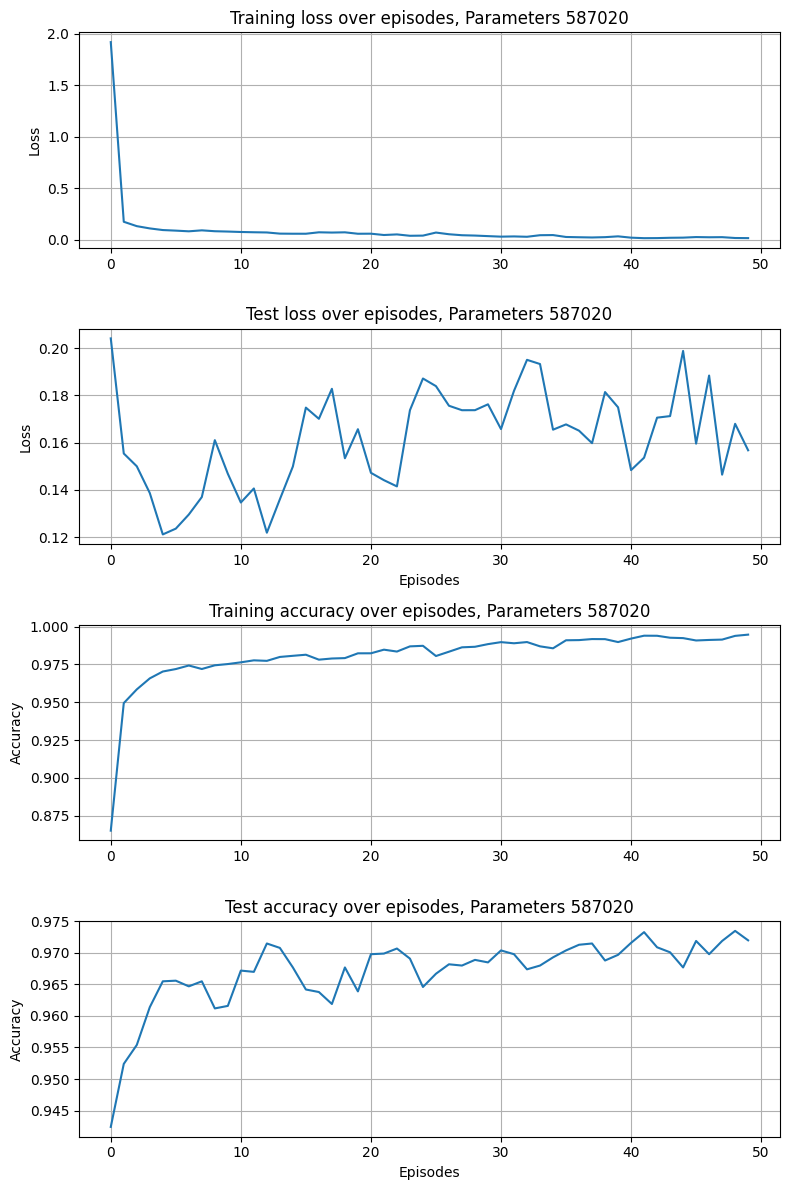

In [19]:
train_loss_mean_perm_nn42 = []
test_loss_mean_perm_nn42 = []
train_acc_mean_perm_nn42 = []
test_acc_mean_perm_nn42 = []
train_loss_mean_perm_nn42, test_loss_mean_perm_nn42, train_acc_mean_perm_nn42, test_acc_mean_perm_nn42 = NN_train_test(train_loader, test_loader, train_loss_mean_perm_nn42, test_loss_mean_perm_nn42, train_acc_mean_perm_nn42, test_acc_mean_perm_nn42, networks[3],"ADAM")
print('train_loss: {}\n test_loss: {}\n train_acc: {}\n test_acc: {}'.format(train_loss_mean_perm_nn42,test_loss_mean_perm_nn42,train_acc_mean_perm_nn42, test_acc_mean_perm_nn42))
plot_loss(train_loss_mean_perm_nn42,test_loss_mean_perm_nn42,train_acc_mean_perm_nn42, test_acc_mean_perm_nn42, parameters(networks[3]))

# Perm Cumulative graphs

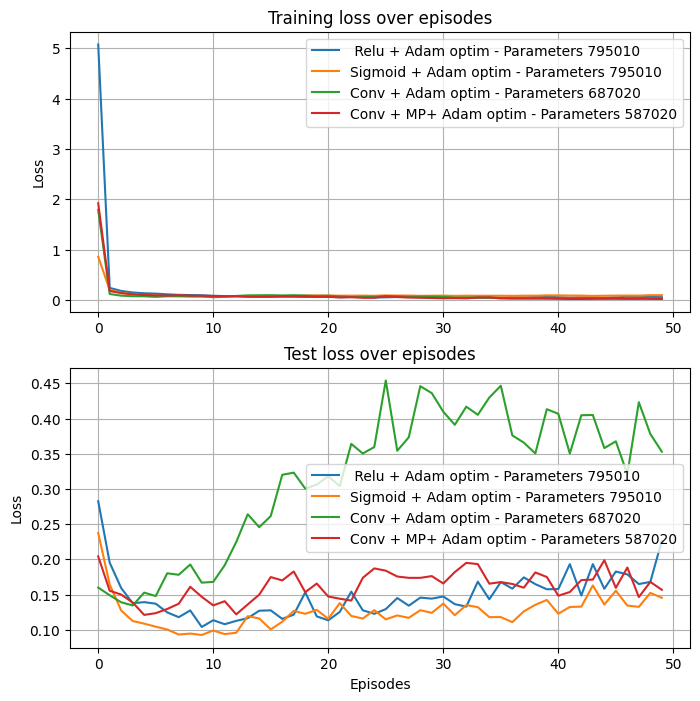

In [20]:
plot_loss_NNs([train_loss_mean_perm_nn12, train_loss_mean_perm_nn22, train_loss_mean_perm_nn32, train_loss_mean_perm_nn42],
          [test_loss_mean_perm_nn12, test_loss_mean_perm_nn22, test_loss_mean_perm_nn32, test_loss_mean_perm_nn42],
          [parameters(networks[0]), parameters(networks[1]), parameters(networks[2]), parameters(networks[3])],"Adam")

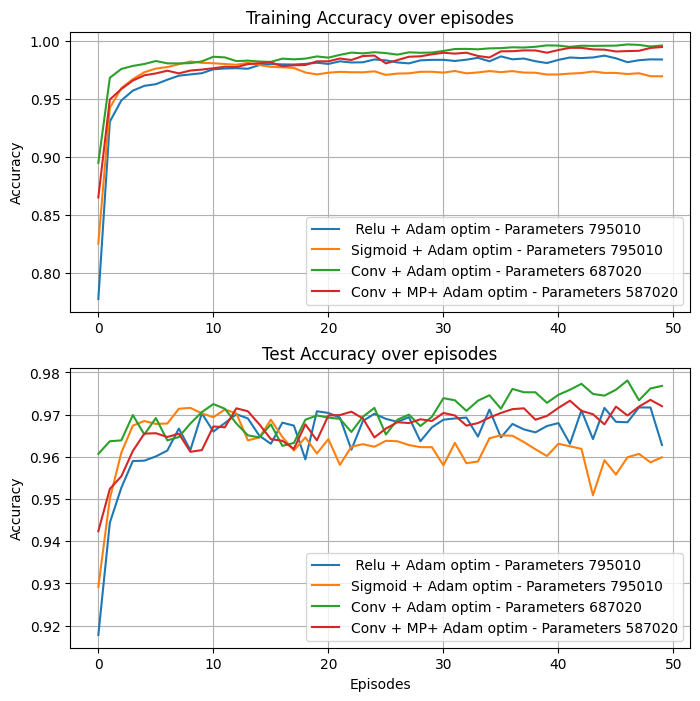

In [21]:
plot_acc_NNs([train_acc_mean_perm_nn12, train_acc_mean_perm_nn22, train_acc_mean_perm_nn32, train_acc_mean_perm_nn42],
          [test_acc_mean_perm_nn12, test_acc_mean_perm_nn22, test_acc_mean_perm_nn32, test_acc_mean_perm_nn42],
          [parameters(networks[0]), parameters(networks[1]), parameters(networks[2]), parameters(networks[3])],"Adam")